In [1]:
import numpy as np
import pandas as pd 
from scipy import stats
import warnings

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_validate

import matplotlib.pyplot as plt
import seaborn as sns

import time
start_time = time.time()
%matplotlib inline

In [2]:
# Import the housing dataset as a Pandas Dataframe
df = pd.read_csv('data/kc_house_data.csv')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [3]:
# Create a summmary of each column in the df
print(df.info())

print('''
yr_renovated and waterfront are only columns containing null values
''')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [4]:
# Set Nan values of 'waterfront' and 'year_renovated' columns to 0
df.loc[df.waterfront.isna()==True, 'waterfront'] = 0
df.loc[df.yr_renovated.isna()==True, 'yr_renovated'] = 0

#Set all sqft_basement values of '?' to 0, then convert to floats.
df.loc[df.sqft_basement=='?', 'sqft_basement'] = 0
df.sqft_basement = df.sqft_basement.astype(float)

# Convert 'date' to a datetime object and use these to create a 'year' column
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].apply(lambda date: date.year)

# Create an 'age' column to specify how old a house was at sale
df['age'] = df['year'] - df['yr_built']

#Drop unnecessary 'id', 'yr_built', 'year', and 'date' columns
cols_to_drop = ['id', 'yr_built', 'year', 'date']
df.drop(cols_to_drop, axis=1, inplace=True)

#Drop rows that contain null values in the 'view' column
df.dropna(subset = ['view'], inplace = True)

## Handling Outliers

In [5]:
# assigning variable for columns we would like to check for outliers
target_cols = ['bathrooms', 'bedrooms', 'sqft_living']

# assigning variable to predefined outlier column names
outlier_cols = ['outlier_' + col for col in target_cols]
z_scores = [stats.zscore(df[col]) 
                for col in target_cols]

# for each column, checking to see if the z-score is above or below 3 standard deviations
for outlier_col, z_score in zip(outlier_cols, z_scores):
    df[outlier_col] = ((z_score > 3) | (z_score <-3))

# initializes an empty query string 
query_empty = '({} == False)&'*(len(target_cols))

# fills in the outlier column names
query = query_empty[:-1].format(*outlier_cols)

# selecting rows that do not have any outliers
df = df.query(query)

# dropping the outlier columns that we just made
df = df.drop(columns=outlier_cols)

# Drop the outlier house that contains 33 bedrooms
df = df[df['bedrooms'] != 33]

# Drop houses that were bought before construction
df = df[df['age'] != -1]

There is a relatively normal distribution of bedroom sizes


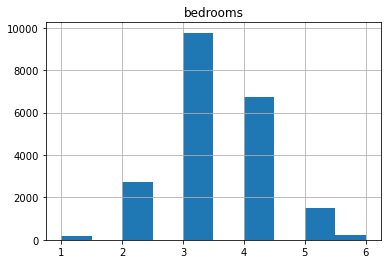

In [6]:
# plotting a histogram to visualize the # of homes sold by # of bedrooms
df.hist('bedrooms');
print('There is a relatively normal distribution of bedroom sizes')

Price has a positive skew


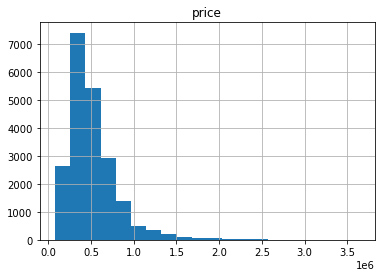

In [7]:
# plotting a histogram to visualize the # of homes sold by price
print("Price has a positive skew")
df.hist('price', bins=20);

In [8]:
# Create a matrix of correlations for each feature set in the dataframe
corr_matrix = df.corr()
# Create a boolean mask for all values on or above the matrix diagonal 
corr_matrix_mask = np.triu(np.ones_like(df.corr(), dtype=bool));

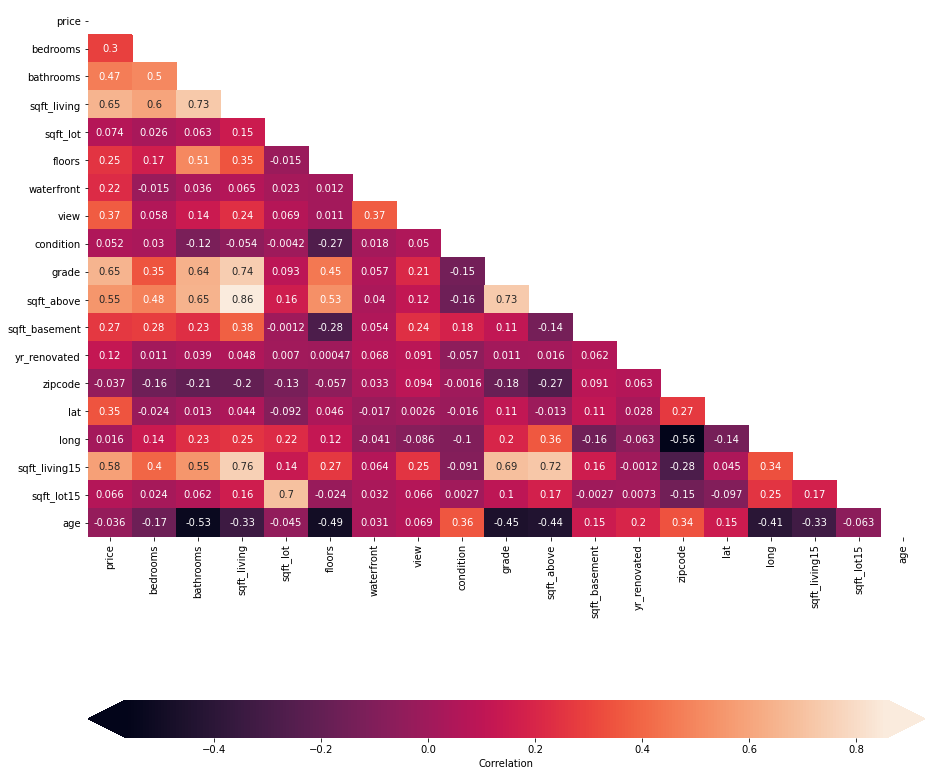

In [9]:
# Creates a heat map of correlation coefficient
fig, ax = plt.subplots(figsize  =(15,15))
sns.heatmap(
            corr_matrix, 
            ax=ax, 
            annot=True, 
            mask= corr_matrix_mask,
            cbar_kws={"label": "Correlation", "orientation": "horizontal", "pad": .2, "extend": "both"}
);

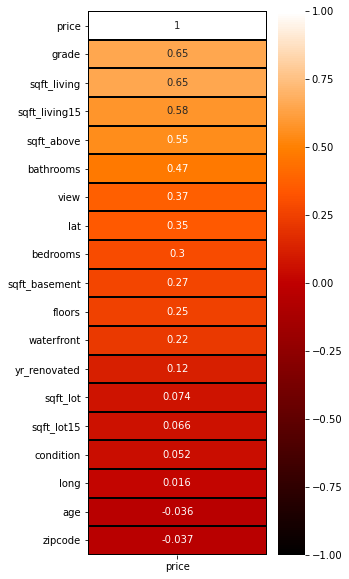

In [10]:
# Price will be our target value to predict, so we'll zero in on its correlations.
plt.figure(figsize=(4,10))
heatmap = sns.heatmap(df.corr()[['price']].sort_values(by='price', ascending=False), vmin=-1, vmax=1, linewidths=1, linecolor='black', annot=True, fmt='.2g', cmap="gist_heat")

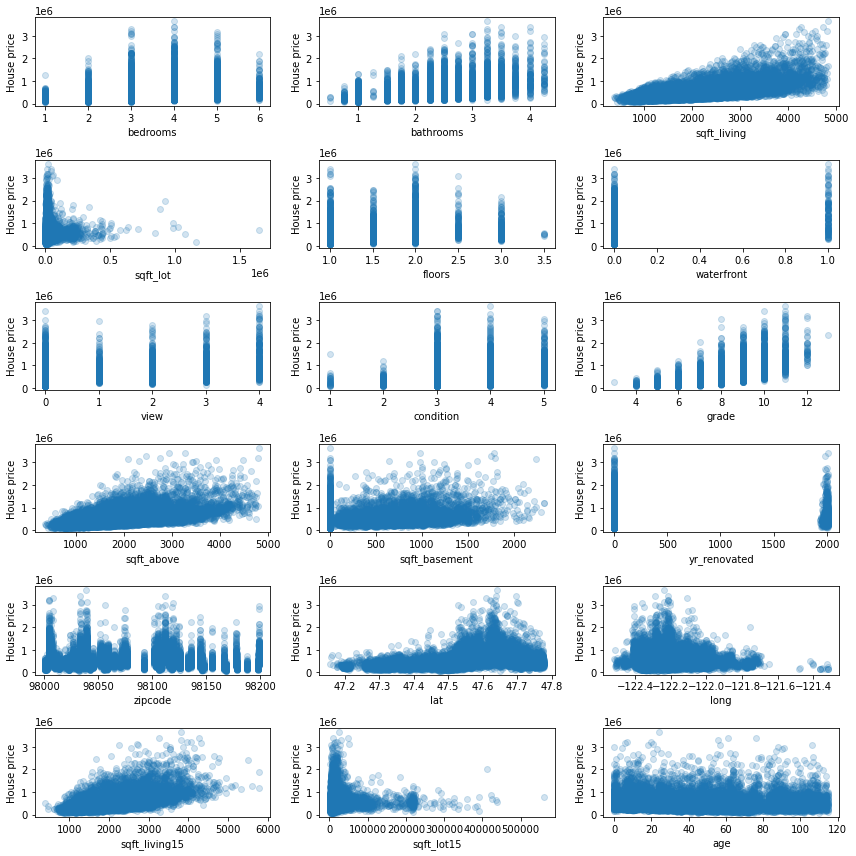

In [11]:
# creating visualizations for each of our features as they relate to the price of houses sold in our dataset

x = df.drop('price', axis=1)
y= df.price
fig, axes = plt.subplots(ncols=3, nrows=6, figsize=(12, 12))
fig.set_tight_layout(True)
for index, col in enumerate(x.columns): 
    ax = axes[index//3][index%3]
    ax.scatter(x[col], y, alpha=0.2)
    ax.set_xlabel(col)
    ax.set_ylabel("House price")

### Average price by Grade

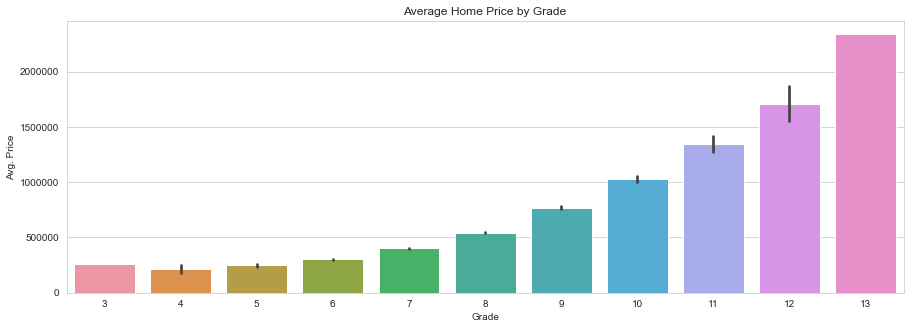

In [12]:
# creating a visualization to understand the mean price of homes sold by each value for grade

sns.set_style('whitegrid')
x = df['grade']
y = df['price']
fig, ax = plt.subplots(figsize = (15, 5))
ax = sns.barplot(x=x,y=y, data=df)
ax.ticklabel_format(style='plain', axis='y')
ax.set(xlabel='Grade', ylabel='Avg. Price')
plt.title("Average Home Price by Grade")
plt.show()

### Average Price by bathrooms

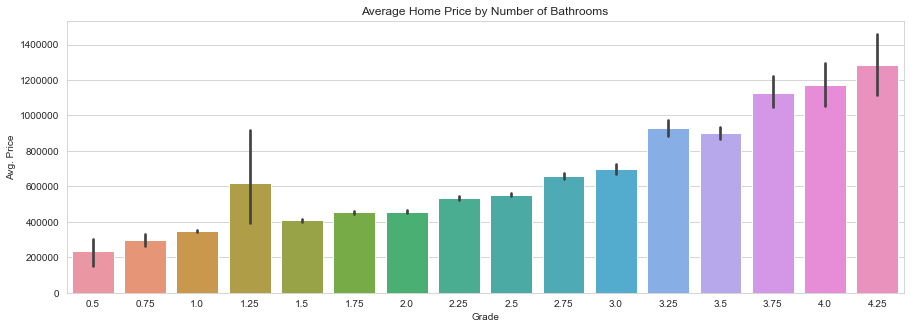

In [13]:
# creating a visualization to understand the mean price of homes sold by number of bathrooms

sns.set_style('whitegrid')
x = df['bathrooms']
y = df['price']
fig, ax = plt.subplots(figsize = (15, 5))
ax = sns.barplot(x=x,y=y, data=df)
ax.ticklabel_format(style='plain', axis='y')
ax.set(xlabel='Grade', ylabel='Avg. Price')
plt.title("Average Home Price by Number of Bathrooms")
plt.show()

## Average Price by View

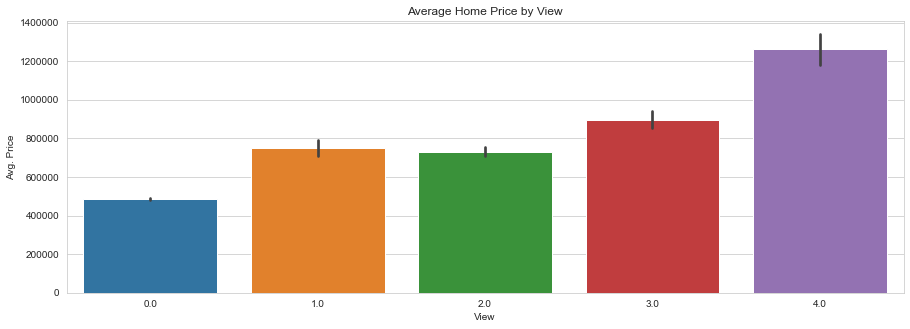

In [14]:
# creating a visualization to understand the mean price of homes sold by number of views

sns.set_style('whitegrid')

x = df['view']
y = df['price']

fig, ax = plt.subplots(figsize = (15, 5))

ax = sns.barplot(x=x,y=y, data=df)

ax.ticklabel_format(style='plain', axis='y')

ax.set(xlabel='View', ylabel='Avg. Price')

plt.title("Average Home Price by View")

plt.show()

### Average Price by Condition

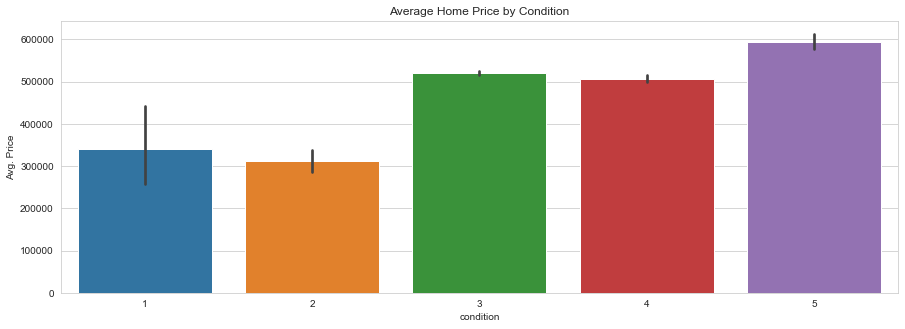

In [15]:
# creating a visualization to understand the mean price of homes sold by condition

sns.set_style('whitegrid')
x = df['condition']
y = df['price']
fig, ax = plt.subplots(figsize = (15, 5))
ax = sns.barplot(x=x,y=y, data=df)
ax.ticklabel_format(style='plain', axis='y')
ax.set(xlabel='condition', ylabel='Avg. Price')
plt.title("Average Home Price by Condition")
plt.show()

### Average Price by Waterfront

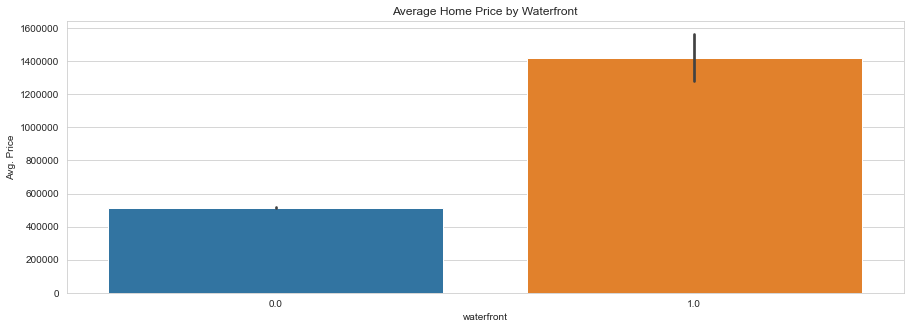

In [16]:
# creating a visualization to understand the mean price of homes sold based on whether or not they are on the water

sns.set_style('whitegrid')
x = df['waterfront']
y = df['price']
fig, ax = plt.subplots(figsize = (15, 5))
ax = sns.barplot(x=x,y=y, data=df)
ax.ticklabel_format(style='plain', axis='y')
ax.set(xlabel='waterfront', ylabel='Avg. Price')
plt.title("Average Home Price by Waterfront")
plt.show()

# Model Building

## Baseline Model

In [17]:
# Drop the new 'age' column and our target column 'price' for the independent features
X = df.drop(['price', 'age'], axis = 1)

# Set our dependent variable as price
y = df.price
  
# Split up our independent and dependent variables into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
# Trains our model on our baseline values

lm_dummy_mean = DummyRegressor(strategy = 'mean').fit(X_train, y_train)

# predicting test prices based on the X_test
y_predict_dummy_mean = lm_dummy_mean.predict(X_test)

rmse_lr0 = mean_squared_error(y_test, y_predict_dummy_mean, squared=False) #y_predict should be y_predict dummy

print(r2_score(y_test, y_predict_dummy_mean), rmse_lr0)

-0.0001926534941929514 302249.8363238796


### Model 1:  including 'age'

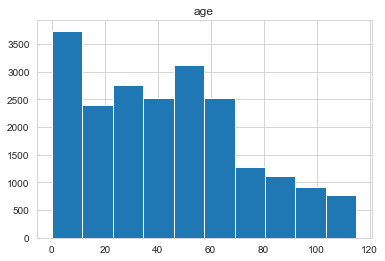

In [19]:
# plotting the # of homes sold by their age
df.hist('age');

In [20]:
# Drop the dependent variable from the independent columns
X = df.drop(['price'], axis = 1)

# Set our dependent variable as price
y = df['price']

# Split up our independent and dependent variables into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 

# do train test split only once to preserve random state

In [21]:
# Initialize an empty regression model
lr = LinearRegression()

# Fits the model to our training dataset
lr.fit(X_train, y_train)

pred_lr1 = lr.predict(X_test)

train_score_lr1 = lr.score(X_train, y_train)
test_score_lr1 = lr.score(X_test, y_test)

In [22]:
lr.coef_[0]

-24532.171636512718

In [23]:
lr.intercept_

-2160858.7749652183

In [24]:
rmse_lr1 = mean_squared_error(y_test, pred_lr1, squared=False)

In [25]:
train_score_lr1, test_score_lr1, rmse_lr1 #(0.7026591179673133, 0.6931727130407752, 205731.06771444588)

(0.6914587184752559, 0.6885558723559322, 168660.86272806223)

In [26]:
scores_simple_1 = cross_validate(
                    lr, X_train, y_train, cv=5, 
                    return_train_score=True
)

simple_1_mean = np.mean(scores_simple_1['train_score'])

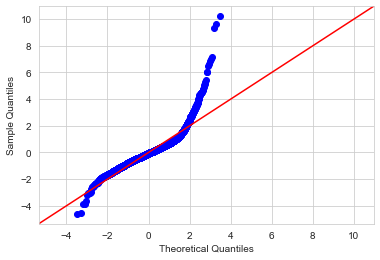

In [27]:
# Checking the QQ Plot to understand the distribution of residuals
residuals1 = (y_test - pred_lr1)
sm.graphics.qqplot(residuals1, dist=stats.norm, line="45", fit=True);

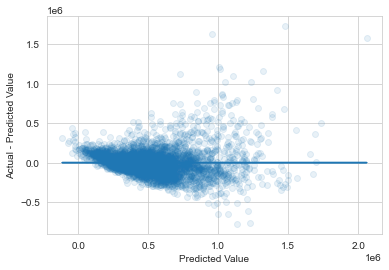

In [28]:
# Checking for homoscedasticity 

residuals1 = (y_test - pred_lr1)
fig, ax = plt.subplots()
ax.scatter(pred_lr1, residuals1, alpha=.1)
ax.plot(pred_lr1, [0 for i in range(len(X_test))])
ax.set_xlabel('Predicted Value')
ax.set_ylabel('Actual - Predicted Value');

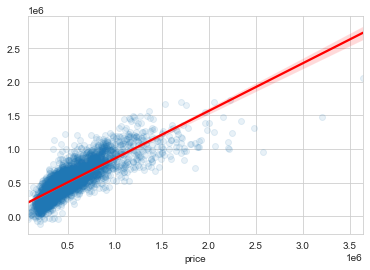

In [29]:
# Checking to see how our regression line fits our data

sns.regplot(x = y_test, y = pred_lr1, data = df, line_kws={'color':'r'}, scatter_kws={'alpha':0.1});

### Model 2: log transform 'price'

In [30]:
# Drop the dependent variable from the independent columns
X = df.drop(['price'], axis = 1)

# Set our dependent variable as the natural log of price
y = np.log(df['price'])

# Split up our independent and dependent variables into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
# Initialize an empty regression model
lr = LinearRegression()

# Fits the model to our training dataset
lr.fit(X_train, y_train)

pred_lr2 = lr.predict(X_test)

In [32]:
# using the score method to see how well our model performed based on how we trained it

train_score_lr2 = lr.score(X_train, y_train)
test_score_lr2 = lr.score(X_test, y_test)

In [33]:
lr.coef_[0] 

-0.01798952328017328

In [34]:
lr.intercept_

-13.94477759740219

In [35]:
# normalizing our price to get an RMSE

rmse_lr2 = mean_squared_error(np.exp(y_test), np.exp(pred_lr2), squared=False)

In [36]:
train_score_lr2, test_score_lr2, rmse_lr2 

(0.7558928001010055, 0.7516799842032745, 164378.8858748426)

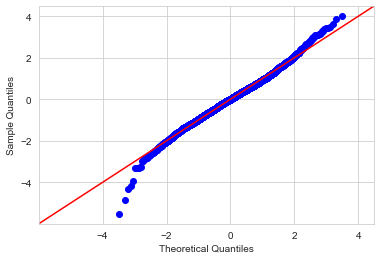

In [37]:
# Checking the QQ Plot to understand the distribution of residuals

residuals2 = (y_test - pred_lr2)
sm.graphics.qqplot(residuals2, dist=stats.norm, line="45", fit=True);

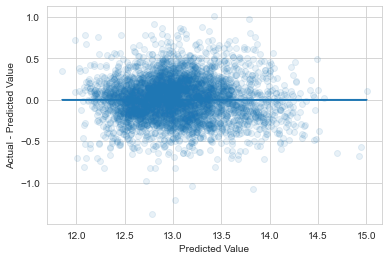

In [38]:
# Checking for homoscedasticity 

residuals2 = (y_test - pred_lr2)
fig, ax = plt.subplots()
ax.scatter(pred_lr2, residuals2, alpha=.1)
ax.plot(pred_lr2, [0 for i in range(len(X_test))])
ax.set_xlabel('Predicted Value')
ax.set_ylabel('Actual - Predicted Value');

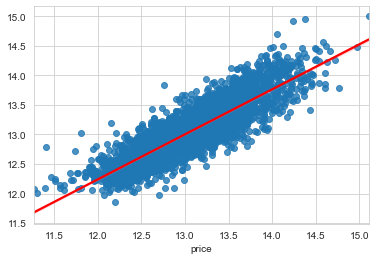

In [39]:
# Checking to see how our regression line fits our data

sns.regplot(x = y_test, y = pred_lr2, data = df, line_kws={'color':'r'});

In [40]:
scores_simple_2 = cross_validate(
                    lr, X_train, y_train, cv=5, 
                    return_train_score=True
)
simple_2_mean = np.mean(scores_simple_2['train_score'])

### Checking the VIF Score

In [41]:
# Making a constant column
df_temp = sm.add_constant(df)

# Checking the Multicollinearity between the features
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(df_temp.values, i) for i in range(df_temp.values.shape[1])]
vif["features"] = df_temp.columns

print(vif.round(1))

    VIF Factor       features
0    4439044.0          const
1          3.2          price
2          1.7       bedrooms
3          3.2      bathrooms
4        131.9    sqft_living
5          2.0       sqft_lot
6          2.1         floors
7          1.2     waterfront
8          1.4           view
9          1.3      condition
10         3.6          grade
11       113.7     sqft_above
12        34.4  sqft_basement
13         1.1   yr_renovated
14         1.7        zipcode
15         1.4            lat
16         1.8           long
17         3.0  sqft_living15
18         2.0     sqft_lot15
19         2.6            age


### Model 3:  creating dummy columns for zip code

In [42]:
# Adds dummy zipcode columns
df = df.join(pd.get_dummies(df['zipcode'], prefix = 'x', drop_first = True))
df.drop('zipcode', axis=1, inplace=True)

In [43]:
# Drop the dependent variable from the independent columns
X = df.drop(['price'], axis = 1)

# Set our dependent variable as the natural log of price
y = np.log(df['price'])

# Split up our independent and dependent variables into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [44]:
# Initialize an empty regression model
lr = LinearRegression()

# Fits the model to our training dataset
lr.fit(X_train, y_train)

LinearRegression()

In [45]:
pred_lr3 = lr.predict(X_test)

In [46]:
# using the score method to see how well our model performed based on how we trained it

train_score_lr3 = lr.score(X_train, y_train)
test_score_lr3 = lr.score(X_test, y_test)

In [47]:
lr.coef_[0]

0.00014056718318265093

In [48]:
lr.intercept_

-55.81823373151189

In [49]:
# normalizing our price to get an RMSE

rmse_lr3 = mean_squared_error(np.exp(y_test), np.exp(pred_lr3), squared=False)

In [50]:
train_score_lr3, test_score_lr3, rmse_lr3 # (0.8783623094453447, 0.8702059345827169, 0.19108859922879654)

(0.8707370644231548, 0.8703464138143138, 121705.58467489011)

In [51]:
# Making an OLS table to check for significance
X = sm.add_constant(X)
sm.OLS(y, X).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.871
Model:                            OLS   Adj. R-squared:                  0.870
Method:                 Least Squares   F-statistic:                     1649.
Date:                Wed, 14 Jul 2021   Prob (F-statistic):               0.00
Time:                        21:14:19   Log-Likelihood:                 6120.4
No. Observations:               21132   AIC:                        -1.207e+04
Df Residuals:                   21045   BIC:                        -1.137e+04
Df Model:                          86                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           -58.0582      7.029     -8.260      0.000     -71.835     -44.281
bedrooms       4.294e-06      0.002      0.002      0.998      -0.004       0.004
bathrooms         0.0478      0.003     15.198      0.000       0.042       0.054
sqft_living       0.0001   1.77e-05      8.016      0.000       0.000       0.000
sqft_lot       5.927e-07   4.42e-08     13.402      0.000    5.06e-07    6.79e-07
floors           -0.0360      0.004     -9.838      0.000      -0.043      -0.029
waterfront        0.4716      0.018     26.078      0.000       0.436       0.507
view              0.0629      0.002     30.904      0.000       0.059       0.067
condition         0.0546      0.002     24.915      0.000       0.050       0.059
grade             0.0887      0.002     42.114      0.000       0.085       0.093
sqft_above     8.245e-05   1.77e-05      4.650      0.000    4.77e-05       0.000
sqft_basement  2.342e-06   1.76e-05      0.133      0.894   -3.21e-05    3.67e-05
yr_renovated   3.557e-05   3.67e-06      9.681      0.000    2.84e-05    4.28e-05
lat               0.5101      0.072      7.044      0.000       0.368       0.652
long             -0.3677      0.052     -7.057      0.000      -0.470      -0.266
sqft_living15  7.429e-05   3.45e-06     21.554      0.000    6.75e-05     8.1e-05
sqft_lot15     2.255e-07   7.23e-08      3.120      0.002    8.39e-08    3.67e-07
age               0.0005   7.38e-05      7.399      0.000       0.000       0.001
x_98002          -0.0117      0.016     -0.709      0.478      -0.044       0.021
x_98003          -0.0050      0.015     -0.338      0.735      -0.034       0.024
x_98004           0.9503      0.027     35.276      0.000       0.897       1.003
x_98005           0.6055      0.029     21.139      0.000       0.549       0.662
x_98006           0.5354      0.024     22.763      0.000       0.489       0.581
x_98007           0.5330      0.030     18.002      0.000       0.475       0.591
x_98008           0.5360      0.028     19.089      0.000       0.481       0.591
x_98010           0.3250      0.025     12.943      0.000       0.276       0.374
x_98011           0.2396      0.037      6.556      0.000       0.168       0.311
x_98014           0.2648      0.040      6.575      0.000       0.186       0.344
x_98019           0.2198      0.040      5.556      0.000       0.142       0.297
x_98022           0.1779      0.022      8.152      0.000       0.135       0.221
x_98023          -0.0718      0.014     -5.307      0.000      -0.098      -0.045
x_98024           0.4145      0.036     11.629      0.000       0.345       0.484
x_98027           0.4694      0.024     19.529      0.000       0.422       0.516
x_98028           0.1956      0.035      5.512      0.000       0.126       0.265
x_98029           0.5626      0.027     20.472   

In [52]:
scores_simple_3 = cross_validate(
                    lr, X_train, y_train, cv=5, 
                    return_train_score=True
)
simple_3_mean = np.mean(scores_simple_3['train_score'])

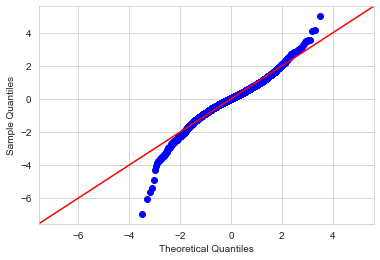

In [53]:
# Making the QQ Plot
residuals3 = (y_test - pred_lr3)
sm.graphics.qqplot(residuals3, dist=stats.norm, line="45", fit=True);

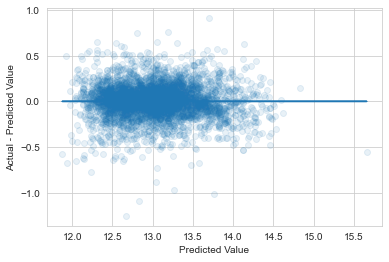

In [54]:
residuals3 = (y_test - pred_lr3)
fig, ax = plt.subplots()
ax.scatter(pred_lr3, residuals3, alpha=.1)
ax.plot(pred_lr3, [0 for i in range(len(X_test))])
ax.set_xlabel('Predicted Value')
ax.set_ylabel('Actual - Predicted Value');

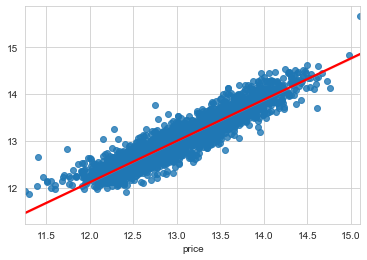

In [55]:
sns.regplot(x = y_test, y = pred_lr3, data = df, line_kws={'color':'r'});

### Model 4:  dropping features with high p_values


In [56]:
# Use summary above to drop features with high p_values
X = df.drop(['price', 'x_98002', 'x_98003', 'sqft_basement', 'bedrooms'], axis = 1)

# Set our dependent variable as the natural log of price
y = np.log(df['price'])

# Split up our independent and dependent variables into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [57]:
# Initialize an empty regression model
lr = LinearRegression()

# Fits the model to our training dataset
lr.fit(X_train, y_train)

LinearRegression()

In [58]:
pred_lr4 = lr.predict(X_test)

In [59]:
train_score_lr4 = lr.score(X_train, y_train)
test_score_lr4 = lr.score(X_test, y_test)

In [60]:
lr.coef_[0]

0.04865482685085614

In [61]:
lr.intercept_

-56.929814275908264

In [62]:
rmse_lr4 = mean_squared_error(np.exp(y_test), np.exp(pred_lr4), squared=False)

In [63]:
train_score_lr4, test_score_lr4, rmse_lr4 # (0.8783495053881852, 0.8702421515098159, 0.19106193728286688)

(0.8707294122768663, 0.8703728279546661, 121678.15586045684)

In [64]:
# Checking the OLS for values of significance
X = sm.add_constant(X)
sm.OLS(y, X).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.871
Model:                            OLS   Adj. R-squared:                  0.870
Method:                 Least Squares   F-statistic:                     1730.
Date:                Wed, 14 Jul 2021   Prob (F-statistic):               0.00
Time:                        21:14:21   Log-Likelihood:                 6120.1
No. Observations:               21132   AIC:                        -1.207e+04
Df Residuals:                   21049   BIC:                        -1.141e+04
Df Model:                          82                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           -58.7215      6.792     -8.645      0.000     -72.035     -45.408
bathrooms         0.0477      0.003     15.452      0.000       0.042       0.054
sqft_living       0.0001   4.13e-06     34.974      0.000       0.000       0.000
sqft_lot        5.93e-07   4.42e-08     13.416      0.000    5.06e-07     6.8e-07
floors           -0.0360      0.004     -9.847      0.000      -0.043      -0.029
waterfront        0.4716      0.018     26.098      0.000       0.436       0.507
view              0.0629      0.002     30.977      0.000       0.059       0.067
condition         0.0546      0.002     24.919      0.000       0.050       0.059
grade             0.0887      0.002     42.446      0.000       0.085       0.093
sqft_above     8.013e-05   4.33e-06     18.488      0.000    7.16e-05    8.86e-05
yr_renovated   3.557e-05   3.67e-06      9.689      0.000    2.84e-05    4.28e-05
lat               0.5093      0.072      7.037      0.000       0.367       0.651
long             -0.3734      0.050     -7.468      0.000      -0.471      -0.275
sqft_living15  7.437e-05   3.44e-06     21.608      0.000    6.76e-05    8.11e-05
sqft_lot15      2.26e-07   7.22e-08      3.130      0.002    8.45e-08    3.68e-07
age               0.0005   7.35e-05      7.414      0.000       0.000       0.001
x_98004           0.9552      0.026     37.042      0.000       0.905       1.006
x_98005           0.6107      0.028     22.175      0.000       0.557       0.665
x_98006           0.5406      0.022     24.381      0.000       0.497       0.584
x_98007           0.5383      0.029     18.887      0.000       0.482       0.594
x_98008           0.5416      0.027     20.149      0.000       0.489       0.594
x_98010           0.3309      0.024     13.967      0.000       0.284       0.377
x_98011           0.2447      0.036      6.862      0.000       0.175       0.315
x_98014           0.2718      0.039      6.963      0.000       0.195       0.348
x_98019           0.2263      0.038      5.877      0.000       0.151       0.302
x_98022           0.1838      0.020      9.091      0.000       0.144       0.223
x_98023          -0.0680      0.011     -5.982      0.000      -0.090      -0.046
x_98024           0.4211      0.034     12.235      0.000       0.354       0.489
x_98027           0.4751      0.023     21.046      0.000       0.431       0.519
x_98028           0.2004      0.035      5.795      0.000       0.133       0.268
x_98029           0.5686      0.026     21.772      0.000       0.517       0.620
x_98030           0.0551      0.014      3.850      0.000       0.027       0.083
x_98031           0.0602      0.015      3.994      0.000       0.031       0.090
x_98032          -0.0672      0.018     -3.705      0.000      -0.103      -0.032
x_98033           0.6107      0.029     20.760   

In [65]:
scores_simple_4 = cross_validate(
                    lr, X_train, y_train, cv=5, 
                    return_train_score=True
)
simple_4_mean = np.mean(scores_simple_4['train_score'])

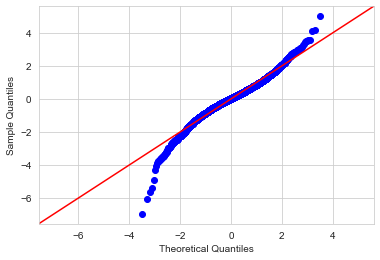

In [66]:
# Making the QQ Plot
residuals4 = (y_test - pred_lr4)
sm.graphics.qqplot(residuals4, dist=stats.norm, line="45", fit=True);

Text(0, 0.5, 'Actual - Predicted Value')

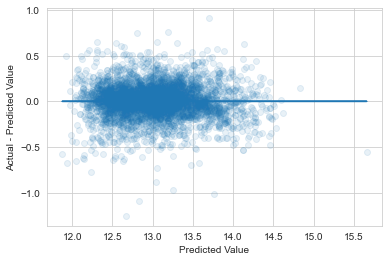

In [67]:
residuals4 = (y_test - pred_lr4)
fig, ax = plt.subplots()
ax.scatter(pred_lr4, residuals4, alpha=.1)
ax.plot(pred_lr4, [0 for i in range(len(X_test))])
ax.set_xlabel('Predicted Value')
ax.set_ylabel('Actual - Predicted Value')

<AxesSubplot:xlabel='price'>

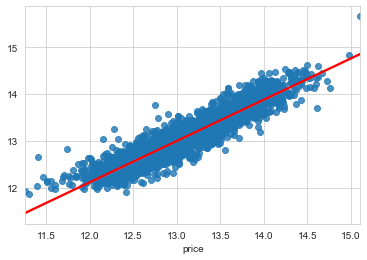

In [68]:
sns.regplot(x = y_test, y = pred_lr4, data = df, line_kws={'color':'r'})

### Model 5: adding back the zipcodes we dropped in our previous model

In [69]:
X = df.drop(['price', 'sqft_basement', 'bedrooms'], axis = 1)
y = df['price'] 
y = np.log(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [70]:
# Initialize an empty regression model
lr = LinearRegression()

# Fits the model to our training dataset
lr.fit(X_train, y_train)

LinearRegression()

In [71]:
pred_lr5 = lr.predict(X_test)

In [72]:
train_score_lr5 = lr.score(X_train, y_train)
test_score_lr5 = lr.score(X_test, y_test)

In [73]:
lr.coef_[0]

0.04867612612889068

In [74]:
lr.intercept_

-55.805606201770765

In [75]:
rmse_lr5 = mean_squared_error(np.exp(y_test), np.exp(pred_lr5), squared=False)

In [76]:
train_score_lr5, test_score_lr5, rmse_lr5

(0.8707340916355739, 0.8703683104897879, 121678.04831268311)

In [77]:
# Checking the OLS for values of significance
X = sm.add_constant(X)
sm.OLS(y, X).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.871
Model:                            OLS   Adj. R-squared:                  0.870
Method:                 Least Squares   F-statistic:                     1689.
Date:                Wed, 14 Jul 2021   Prob (F-statistic):               0.00
Time:                        21:14:23   Log-Likelihood:                 6120.4
No. Observations:               21132   AIC:                        -1.207e+04
Df Residuals:                   21047   BIC:                        -1.139e+04
Df Model:                          84                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           -58.0580      7.029     -8.260      0.000     -71.835     -44.281
bathrooms         0.0478      0.003     15.457      0.000       0.042       0.054
sqft_living       0.0001   4.13e-06     34.970      0.000       0.000       0.000
sqft_lot       5.927e-07   4.42e-08     13.407      0.000    5.06e-07    6.79e-07
floors           -0.0360      0.004     -9.839      0.000      -0.043      -0.029
waterfront        0.4716      0.018     26.098      0.000       0.436       0.507
view              0.0629      0.002     30.981      0.000       0.059       0.067
condition         0.0546      0.002     24.921      0.000       0.050       0.059
grade             0.0887      0.002     42.393      0.000       0.085       0.093
sqft_above     8.016e-05   4.34e-06     18.490      0.000    7.17e-05    8.87e-05
yr_renovated   3.557e-05   3.67e-06      9.689      0.000    2.84e-05    4.28e-05
lat               0.5102      0.072      7.047      0.000       0.368       0.652
long             -0.3677      0.052     -7.057      0.000      -0.470      -0.266
sqft_living15  7.429e-05   3.44e-06     21.574      0.000    6.75e-05     8.1e-05
sqft_lot15     2.254e-07   7.22e-08      3.121      0.002    8.38e-08    3.67e-07
age               0.0005   7.36e-05      7.427      0.000       0.000       0.001
x_98002          -0.0117      0.016     -0.709      0.478      -0.044       0.021
x_98003          -0.0050      0.015     -0.339      0.735      -0.034       0.024
x_98004           0.9502      0.027     35.278      0.000       0.897       1.003
x_98005           0.6055      0.029     21.141      0.000       0.549       0.662
x_98006           0.5354      0.024     22.765      0.000       0.489       0.581
x_98007           0.5330      0.030     18.008      0.000       0.475       0.591
x_98008           0.5360      0.028     19.097      0.000       0.481       0.591
x_98010           0.3249      0.025     12.943      0.000       0.276       0.374
x_98011           0.2396      0.037      6.556      0.000       0.168       0.311
x_98014           0.2648      0.040      6.574      0.000       0.186       0.344
x_98019           0.2198      0.040      5.556      0.000       0.142       0.297
x_98022           0.1779      0.022      8.152      0.000       0.135       0.221
x_98023          -0.0718      0.014     -5.308      0.000      -0.098      -0.045
x_98024           0.4145      0.036     11.629      0.000       0.345       0.484
x_98027           0.4693      0.024     19.530      0.000       0.422       0.516
x_98028           0.1956      0.035      5.511      0.000       0.126       0.265
x_98029           0.5625      0.027     20.472      0.000       0.509       0.616
x_98030           0.0503      0.016      3.115      0.002       0.019       0.082
x_98031           0.0553      0.017      3.283   

In [78]:
scores_simple_5 = cross_validate(
                    lr, X_train, y_train, cv=5, 
                    return_train_score=True
)
simple_5_mean = np.mean(scores_simple_5['train_score'])

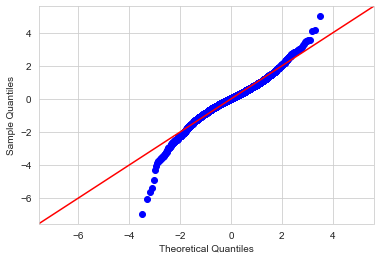

In [79]:
residuals5 = (y_test - pred_lr5)
sm.graphics.qqplot(residuals5, dist=stats.norm, line="45", fit=True);

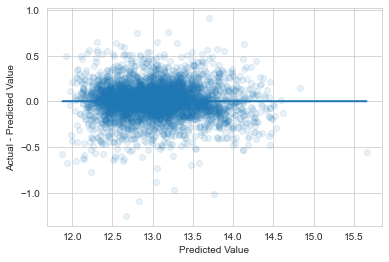

In [80]:
residuals5 = (y_test - pred_lr4)
fig, ax = plt.subplots()
ax.scatter(pred_lr5, residuals5, alpha=.1)
ax.plot(pred_lr5, [0 for i in range(len(X_test))])
ax.set_xlabel('Predicted Value')
ax.set_ylabel('Actual - Predicted Value');

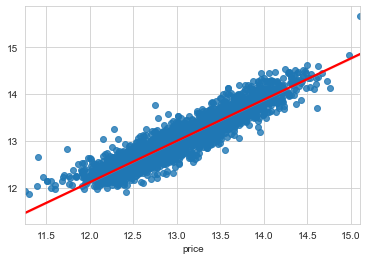

In [81]:
sns.regplot(x = y_test, y = pred_lr5, data = df, line_kws={'color':'r'});

### Model 6: Our best LR model

In [82]:
X = df.drop(['price', 'sqft_basement', 'bedrooms', 'sqft_above'], axis = 1)
y = df['price'] 
y = np.log(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [83]:
lr = LinearRegression()
lr.fit(X_train, y_train)
pred_lr6 = lr.predict(X_test)

train_score_lr6 = lr.score(X_train, y_train)
test_score_lr6 = lr.score(X_test, y_test)

lr.coef_[0]
lr.intercept_
rmse_lr6 = mean_squared_error(np.exp(y_test), np.exp(pred_lr6), squared=False)

In [84]:
train_score_lr6, test_score_lr6, rmse_lr6 #(0.8765432246064853, 0.8686285930439092, 0.19224620904784312)

(0.868562897452934, 0.868558305078146, 120124.9421814577)

In [85]:
X = sm.add_constant(X)
sm.OLS(y, X).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.868
Method:                 Least Squares   F-statistic:                     1678.
Date:                Wed, 14 Jul 2021   Prob (F-statistic):               0.00
Time:                        21:14:24   Log-Likelihood:                 5950.1
No. Observations:               21132   AIC:                        -1.173e+04
Df Residuals:                   21048   BIC:                        -1.106e+04
Df Model:                          83                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           -54.8549      7.083     -7.744      0.000     -68.738     -40.971
bathrooms         0.0385      0.003     12.524      0.000       0.032       0.045
sqft_living       0.0002   3.19e-06     60.832      0.000       0.000       0.000
sqft_lot       6.107e-07   4.46e-08     13.706      0.000    5.23e-07    6.98e-07
floors           -0.0023      0.003     -0.723      0.469      -0.009       0.004
waterfront        0.4750      0.018     26.077      0.000       0.439       0.511
view              0.0574      0.002     28.349      0.000       0.053       0.061
condition         0.0510      0.002     23.175      0.000       0.047       0.055
grade             0.0963      0.002     46.528      0.000       0.092       0.100
yr_renovated   3.438e-05    3.7e-06      9.290      0.000    2.71e-05    4.16e-05
lat               0.5068      0.073      6.944      0.000       0.364       0.650
long             -0.3424      0.052     -6.522      0.000      -0.445      -0.239
sqft_living15  8.247e-05   3.44e-06     23.957      0.000    7.57e-05    8.92e-05
sqft_lot15     2.333e-07   7.28e-08      3.204      0.001    9.06e-08    3.76e-07
age               0.0007   7.37e-05      9.339      0.000       0.001       0.001
x_98002          -0.0085      0.017     -0.510      0.610      -0.041       0.024
x_98003          -0.0081      0.015     -0.549      0.583      -0.037       0.021
x_98004           0.9427      0.027     34.722      0.000       0.889       0.996
x_98005           0.5934      0.029     20.559      0.000       0.537       0.650
x_98006           0.5186      0.024     21.894      0.000       0.472       0.565
x_98007           0.5227      0.030     17.522      0.000       0.464       0.581
x_98008           0.5268      0.028     18.619      0.000       0.471       0.582
x_98010           0.3233      0.025     12.777      0.000       0.274       0.373
x_98011           0.2330      0.037      6.325      0.000       0.161       0.305
x_98014           0.2580      0.041      6.355      0.000       0.178       0.338
x_98019           0.2133      0.040      5.349      0.000       0.135       0.291
x_98022           0.1794      0.022      8.154      0.000       0.136       0.223
x_98023          -0.0749      0.014     -5.495      0.000      -0.102      -0.048
x_98024           0.4100      0.036     11.413      0.000       0.340       0.480
x_98027           0.4504      0.024     18.612      0.000       0.403       0.498
x_98028           0.1870      0.036      5.227      0.000       0.117       0.257
x_98029           0.5512      0.028     19.903      0.000       0.497       0.605
x_98030           0.0487      0.016      2.992      0.003       0.017       0.081
x_98031           0.0499      0.017      2.942      0.003       0.017       0.083
x_98032          -0.0807      0.020     -4.094   

In [86]:
scores_simple_6 = cross_validate(
                    lr, X_train, y_train, cv=5, 
                    return_train_score=True
)
simple_6_mean = np.mean(scores_simple_6['train_score'])

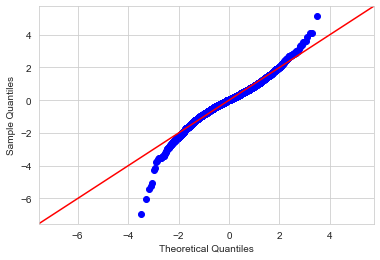

In [87]:
# Making the QQ Plot
residuals6 = (y_test - pred_lr6)
sm.graphics.qqplot(residuals6, dist=stats.norm, line="45", fit=True);

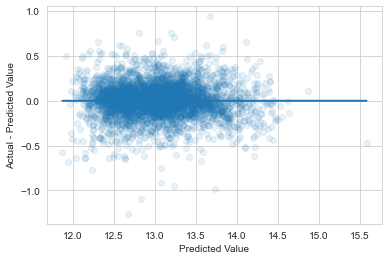

In [88]:
residuals6 = (y_test - pred_lr6)
fig, ax = plt.subplots()
ax.scatter(pred_lr6, residuals6, alpha=.1)
ax.plot(pred_lr6, [0 for i in range(len(X_test))])
ax.set_xlabel('Predicted Value')
ax.set_ylabel('Actual - Predicted Value');

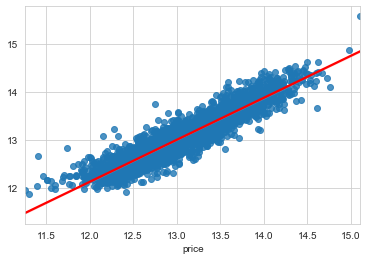

In [89]:
sns.regplot(x = y_test, y = pred_lr6, data = df, line_kws={'color':'r'});

### Model 7:  Polynomial Regression

In [90]:
X = df.drop(['price', 'sqft_basement', 'sqft_lot15', 'sqft_above', 'bathrooms', 'sqft_living', 'grade'], axis = 1)
y = df['price'] 
# y = np.log(y)
# ss = StandardScaler()
# X = ss.fit_transform(X)

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [92]:
poly = PolynomialFeatures(2)

In [93]:
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

In [94]:
lr = LinearRegression()

In [95]:
lr.fit(X_train_poly, y_train)

LinearRegression()

In [96]:
score_train_poly = lr.score(X_train_poly, y_train)
score_test_poly = lr.score(X_test_poly,y_test)

In [97]:
pred_poly = lr.predict(X_test_poly)

In [98]:
rmse_poly_7 = mean_squared_error(y_test, pred_poly, squared=False)

In [99]:
score_train_poly, score_test_poly, rmse_poly_7 #(0.9311304132469491, 0.8807643708530817, 128249.56887121135)

(0.8536421577113898, 0.8052442710349483, 133373.4437971592)

In [100]:
X_poly = poly.fit_transform(X_train)

In [101]:
scores_complex_1 = cross_validate(
                    lr, X_poly, y_train, cv=5, 
                    return_train_score=True
)
scores_complex_1 = np.mean(scores_complex_1['train_score'])

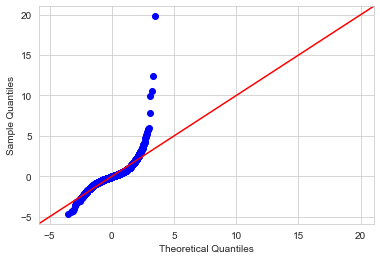

In [102]:
residuals = (y_test - pred_poly)
sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True);

Text(0, 0.5, 'Actual - Predicted Value')

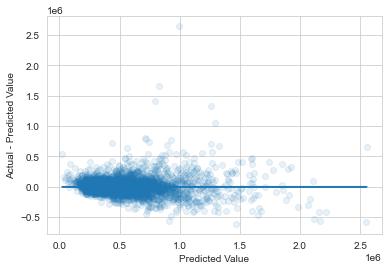

In [103]:
residuals = (y_test - pred_poly)
fig, ax = plt.subplots()
ax.scatter(pred_poly, residuals, alpha=.1)
ax.plot(pred_poly, [0 for i in range(len(X_test))])
ax.set_xlabel('Predicted Value')
ax.set_ylabel('Actual - Predicted Value')

<AxesSubplot:xlabel='price'>

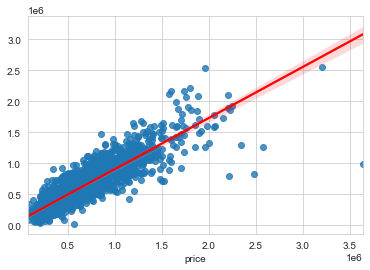

In [104]:
sns.regplot(x = y_test, y = pred_poly, data = df, line_kws={'color':'r'})

### Model 8: Linear Regression with Feature Engineering

In [105]:
# Feature Engineering Making 4 new colmns - here we are turning grade into a polynomial and multiplying it by existing features which improves the correlation to price compared to using the initial features.
df['grade_sqft_living'] = (df.grade**2) * df.sqft_living
df['grade_sqft_above'] = (df.grade**2) * df.sqft_above
df['grade_sqft_living15'] = (df.grade**2) * df.sqft_living15
df['grade_bathrooms'] = (df.grade**2) * df.bathrooms

In [106]:
# Droping columns that are not going to be used 
X = df.drop(['price', 'sqft_basement', 'sqft_lot15', 'sqft_above', 'bathrooms', 'sqft_living', 'grade'], axis = 1)
y = df['price'] 
y = np.log(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [107]:
# Initialize an empty regression model
lr = LinearRegression()

# Fits the model to our training dataset
lr.fit(X_train, y_train)

LinearRegression()

In [108]:
pred_lr8 = lr.predict(X_test)

In [109]:
train_score_lr8 = lr.score(X_train, y_train)
test_score_lr8 = lr.score(X_test, y_test)

In [110]:
lr.coef_[0]

0.018665680058241374

In [111]:
lr.intercept_

-58.144175791769094

In [112]:
rmse_lr8 = mean_squared_error(np.exp(y_test), np.exp(pred_lr8), squared=False)

In [113]:
train_score_lr8, test_score_lr8, rmse_lr8 #(0.8571154620484464, 0.8450870182567047, 0.20876191193343574)

(0.857820485706503, 0.8582847155879496, 137291.6423007392)

In [114]:
# Checking OLS for values of significance
X = sm.add_constant(X)
sm.OLS(y, X).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.858
Method:                 Least Squares   F-statistic:                     1515.
Date:                Wed, 14 Jul 2021   Prob (F-statistic):               0.00
Time:                        21:15:55   Log-Likelihood:                 5127.3
No. Observations:               21132   AIC:                        -1.008e+04
Df Residuals:                   21047   BIC:                            -9408.
Df Model:                          84                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 -61.0405      7.353     -8.301      0.000     -75.453     -46.628
bedrooms                0.0177      0.002      9.195      0.000       0.014       0.022
sqft_lot             6.525e-07   3.61e-08     18.087      0.000    5.82e-07    7.23e-07
floors                 -0.0138      0.004     -3.722      0.000      -0.021      -0.007
waterfront              0.4614      0.019     24.337      0.000       0.424       0.499
view                    0.0651      0.002     30.254      0.000       0.061       0.069
condition               0.0615      0.002     26.880      0.000       0.057       0.066
yr_renovated         4.802e-05   3.84e-06     12.507      0.000    4.05e-05    5.55e-05
lat                     0.5372      0.076      7.079      0.000       0.388       0.686
long                   -0.3859      0.054     -7.082      0.000      -0.493      -0.279
sqft_living15           0.0003   6.16e-06     45.735      0.000       0.000       0.000
age                 -2.913e-05   7.48e-05     -0.390      0.697      -0.000       0.000
x_98002                -0.0189      0.017     -1.097      0.273      -0.053       0.015
x_98003                 0.0062      0.015      0.405      0.685      -0.024       0.036
x_98004                 0.9321      0.028     33.021      0.000       0.877       0.987
x_98005                 0.6238      0.030     20.788      0.000       0.565       0.683
x_98006                 0.5483      0.025     22.256      0.000       0.500       0.597
x_98007                 0.5437      0.031     17.531      0.000       0.483       0.604
x_98008                 0.5430      0.029     18.458      0.000       0.485       0.601
x_98010                 0.3173      0.026     12.060      0.000       0.266       0.369
x_98011                 0.2326      0.038      6.072      0.000       0.157       0.308
x_98014                 0.2560      0.042      6.063      0.000       0.173       0.339
x_98019                 0.2084      0.041      5.024      0.000       0.127       0.290
x_98022                 0.1871      0.023      8.180      0.000       0.142       0.232
x_98023                -0.0663      0.014     -4.679      0.000      -0.094      -0.039
x_98024                 0.4169      0.037     11.162      0.000       0.344       0.490
x_98027                 0.4670      0.025     18.545      0.000       0.418       0.516
x_98028                 0.1873      0.037      5.034      0.000       0.114       0.260
x_98029                 0.5761      0.029     20.026      0.000       0.520       0.633
x_98030                 0.0502      0.017      2.971      0.003       0.017       0.083
x_98031                 0.0510      0.018      2.892      0.004       0.016       0.086
x_98032                -0.0697      0.021     -3.400      0.001      -0.110      -0.030
x_9

In [115]:
simple_7_mean = cross_validate(
                    lr, X_train, y_train, cv=5, 
                    return_train_score=True
)
scores_simple_7 = np.mean(simple_7_mean['train_score'])

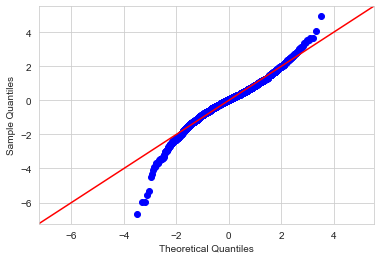

In [116]:
residuals8 = (y_test - pred_lr8)
sm.graphics.qqplot(residuals8, dist=stats.norm, line="45", fit=True);

Text(0, 0.5, 'Actual - Predicted Value')

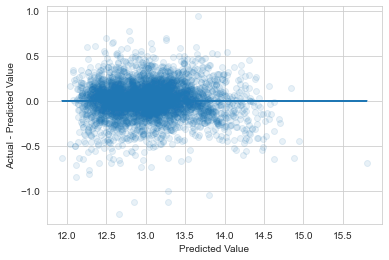

In [117]:
residuals8 = (y_test - pred_lr8)
fig, ax = plt.subplots()
ax.scatter(pred_lr8, residuals8, alpha=.1)
ax.plot(pred_lr8, [0 for i in range(len(X_test))])
ax.set_xlabel('Predicted Value')
ax.set_ylabel('Actual - Predicted Value')

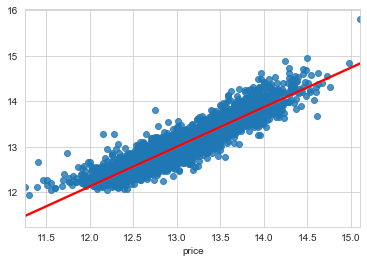

In [118]:
sns.regplot(x = y_test, y = pred_lr8, data = df, line_kws={'color':'r'});

### Model 9: A Polynomial model with feature engineering

In [119]:
df['grade_sqft_living'] = (df.grade**2) * df.sqft_living
df['grade_sqft_above'] = (df.grade**2) * df.sqft_above
df['grade_sqft_living15'] = (df.grade**2) * df.sqft_living15
df['grade_bathrooms'] = (df.grade**2) * df.bathrooms

In [120]:
X = df.drop(['price', 'sqft_basement', 'sqft_lot15', 'sqft_above', 'bathrooms', 'sqft_living', 'grade'], axis = 1)
y = df['price'] 
# y = np.log(y)

# ss = StandardScaler()
# X = ss.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [121]:
poly = PolynomialFeatures(2)

In [122]:
X_train_poly = poly.fit_transform(X_train)

In [123]:
X_test_poly = poly.transform(X_test)

In [124]:
lr = LinearRegression()

In [125]:
lr.fit(X_train_poly, y_train)

LinearRegression()

In [126]:
score_train_poly = lr.score(X_train_poly, y_train)

In [127]:
score_test_poly = lr.score(X_test_poly,y_test)

In [128]:
pred_poly = lr.predict(X_test_poly)

In [129]:
rmse_poly_9 = mean_squared_error(y_test, pred_poly, squared=False)

In [130]:
score_train_poly, score_test_poly, rmse_poly_9 #(0.9311304132469491, 0.8807643708530817, 128249.56887121135)

(0.9148897728056591, 0.8825854557587928, 103558.36677757352)

In [131]:
X_poly = poly.fit_transform(X_train)

model_1 = LinearRegression()

scores_complex_2 = cross_validate(
                    model_1, X_poly, y_train, cv=5, 
                    return_train_score=True
)

scores_complex_2 = np.mean(scores_complex_2['train_score'])

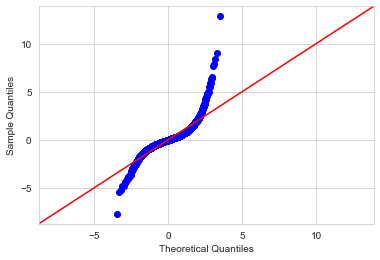

In [132]:
residuals = (y_test - pred_poly)
sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True);

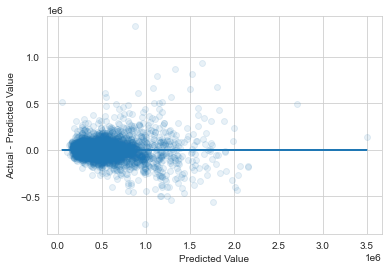

In [133]:
residuals = (y_test - pred_poly)
fig, ax = plt.subplots()
ax.scatter(pred_poly, residuals, alpha=.1)
ax.plot(pred_poly, [0 for i in range(len(X_test))])
ax.set_xlabel('Predicted Value')
ax.set_ylabel('Actual - Predicted Value');

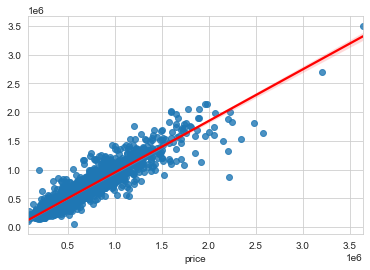

In [134]:
sns.regplot(x = y_test, y = pred_poly, data = df, line_kws={'color':'r'});

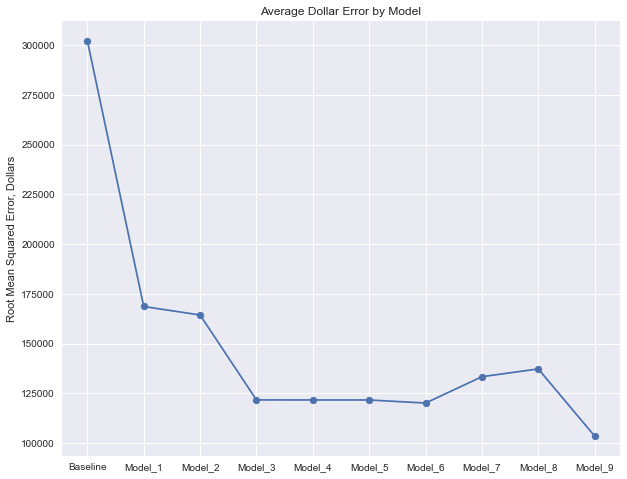

In [135]:
# plotting the RMSE's for each of the models we created - the RMSE's represent the difference between our actual test scores vs. our predicted test scores

models = ['Baseline', 'Model_1', 'Model_2', 'Model_3', 'Model_4', 'Model_5', 
          'Model_6', 'Model_7', 'Model_8', 'Model_9']
RMSE = [rmse_lr0, rmse_lr1, rmse_lr2, rmse_lr3, rmse_lr4, rmse_lr5, rmse_lr6, rmse_poly_7, rmse_lr8, rmse_poly_9]
plt.style.use('seaborn')
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(models, RMSE);
ax.scatter(models, RMSE);
ax.set_ylabel('Root Mean Squared Error, Dollars')
ax.set_title('Average Dollar Error by Model');

In [136]:
x_ = np.array([simple_1_mean,
    simple_2_mean,
    simple_3_mean,
    simple_4_mean,
    simple_5_mean,
    simple_6_mean,
    scores_complex_1,
    scores_simple_7,
    scores_complex_2])

In [137]:
p = 0
for i in x_:
    p += 1
    print(f'The Train Score was {round(i, 3)} in model {p}')
print('\n')
print(f'The Max Train score is {x_.max()}')

The Train Score was 0.692 in model 1
The Train Score was 0.756 in model 2
The Train Score was 0.871 in model 3
The Train Score was 0.871 in model 4
The Train Score was 0.871 in model 5
The Train Score was 0.869 in model 6
The Train Score was 0.859 in model 7
The Train Score was 0.858 in model 8
The Train Score was 0.918 in model 9


The Max Train score is 0.9180671148502743


In [138]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 221.7805769443512 seconds ---


# BREAK

In [139]:
# Adds dummy zipcode columns
df = df.join(pd.get_dummies(df['bedrooms'], prefix = 'x', drop_first = True))
df.drop('bedrooms', axis=1, inplace=True)

In [140]:
df.head()

,price,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,...,x_98199,grade_sqft_living,grade_sqft_above,grade_sqft_living15,grade_bathrooms,x_2,x_3,x_4,x_5,x_6
0,221900.0,1.00,1180,5650,1.0,0.0,0.0,3,7,1180,...,0,57820,57820,65660,49.00,0,1,0,0,0
1,538000.0,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,...,0,125930,106330,82810,110.25,0,1,0,0,0
2,180000.0,1.00,770,10000,1.0,0.0,0.0,3,6,770,...,0,27720,27720,97920,36.00,1,0,0,0,0
3,604000.0,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,...,0,96040,51450,66640,147.00,0,0,1,0,0
4,510000.0,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,...,0,107520,107520,115200,128.00,0,1,0,0,0


In [141]:
# Drop the dependent variable from the independent columns
X = df.drop(['price'], axis = 1)

# Set our dependent variable as the natural log of price
y = np.log(df['price'])

# Split up our independent and dependent variables into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [142]:
# Initialize an empty regression model
lr = LinearRegression()

# Fits the model to our training dataset
lr.fit(X_train, y_train)

LinearRegression()

In [143]:
pred_lr3 = lr.predict(X_test)

In [144]:
# using the score method to see how well our model performed based on how we trained it

train_score_lr3 = lr.score(X_train, y_train)
test_score_lr3 = lr.score(X_test, y_test)

In [145]:
lr.coef_[0]

0.02002964471726201

In [146]:
lr.intercept_

-51.50892744531388

In [147]:
# normalizing our price to get an RMSE

rmse_lr3 = mean_squared_error(np.exp(y_test), np.exp(pred_lr3), squared=False)

In [148]:
train_score_lr3, test_score_lr3, rmse_lr3 # (0.8783623094453447, 0.8702059345827169, 0.19108859922879654)

(0.8730615471442693, 0.873378914703145, 116035.40847046372)

In [149]:
# Making an OLS table to check for significance
X = sm.add_constant(X)
sm.OLS(y, X).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.873
Model:                            OLS   Adj. R-squared:                  0.873
Method:                 Least Squares   F-statistic:                     1542.
Date:                Wed, 14 Jul 2021   Prob (F-statistic):               0.00
Time:                        21:17:49   Log-Likelihood:                 6324.8
No. Observations:               21132   AIC:                        -1.246e+04
Df Residuals:                   21037   BIC:                        -1.170e+04
Df Model:                          94                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 -52.1674      6.972     -7.482      0.000     -65.834     -38.501
bathrooms               0.0060      0.010      0.616      0.538      -0.013       0.025
sqft_living             0.0002   2.18e-05      7.384      0.000       0.000       0.000
sqft_lot             5.791e-07    4.4e-08     13.163      0.000    4.93e-07    6.65e-07
floors                 -0.0408      0.004    -11.149      0.000      -0.048      -0.034
waterfront              0.4769      0.018     26.606      0.000       0.442       0.512
view                    0.0634      0.002     31.028      0.000       0.059       0.067
condition               0.0529      0.002     24.232      0.000       0.049       0.057
grade                   0.1251      0.004     33.135      0.000       0.118       0.133
sqft_above           9.589e-05    2.1e-05      4.567      0.000    5.47e-05       0.000
sqft_basement       -1.593e-06   1.74e-05     -0.092      0.927   -3.57e-05    3.25e-05
yr_renovated         3.236e-05   3.65e-06      8.869      0.000    2.52e-05    3.95e-05
lat                     0.5152      0.072      7.183      0.000       0.375       0.656
long                   -0.3148      0.052     -6.087      0.000      -0.416      -0.213
sqft_living15           0.0002   9.69e-06     16.988      0.000       0.000       0.000
sqft_lot15           2.019e-07   7.17e-08      2.818      0.005    6.15e-08    3.42e-07
age                     0.0007   7.42e-05      9.748      0.000       0.001       0.001
x_98002                -0.0006      0.016     -0.037      0.970      -0.033       0.031
x_98003                -0.0058      0.015     -0.398      0.691      -0.034       0.023
x_98004                 0.9433      0.027     35.298      0.000       0.891       0.996
x_98005                 0.5999      0.028     21.134      0.000       0.544       0.656
x_98006                 0.5378      0.023     23.074      0.000       0.492       0.583
x_98007                 0.5245      0.029     17.872      0.000       0.467       0.582
x_98008                 0.5218      0.028     18.745      0.000       0.467       0.576
x_98010                 0.3167      0.025     12.731      0.000       0.268       0.366
x_98011                 0.2279      0.036      6.292      0.000       0.157       0.299
x_98014                 0.2463      0.040      6.170      0.000       0.168       0.325
x_98019                 0.1979      0.039      5.046      0.000       0.121       0.275
x_98022                 0.1645      0.022      7.604      0.000       0.122       0.207
x_98023                -0.0687      0.013     -5.123      0.000      -0.095      -0.042
x_98024                 0.3959      0.035     11.206      0.000       0.327       0.465
x_98027                 0.4594      0.024     19.278      0.000       0.413       0.506
x_9

In [150]:
scores_simple_3 = cross_validate(
                    lr, X_train, y_train, cv=5, 
                    return_train_score=True
)
simple_3_mean = np.mean(scores_simple_3['train_score'])

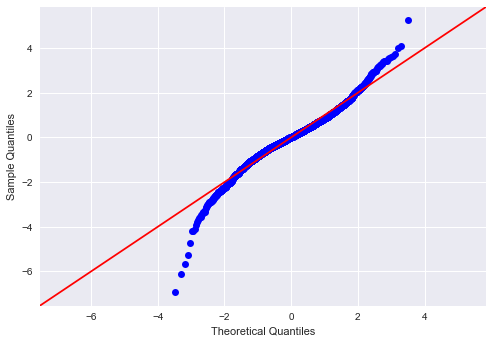

In [151]:
# Making the QQ Plot
residuals3 = (y_test - pred_lr3)
sm.graphics.qqplot(residuals3, dist=stats.norm, line="45", fit=True);

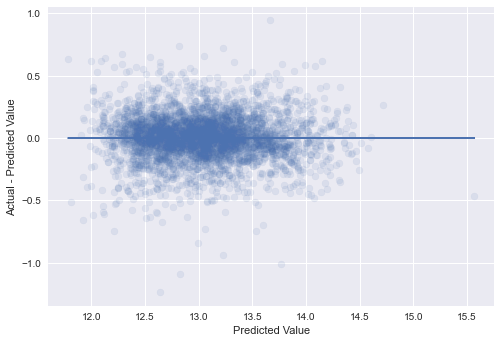

In [152]:
residuals3 = (y_test - pred_lr3)
fig, ax = plt.subplots()
ax.scatter(pred_lr3, residuals3, alpha=.1)
ax.plot(pred_lr3, [0 for i in range(len(X_test))])
ax.set_xlabel('Predicted Value')
ax.set_ylabel('Actual - Predicted Value');

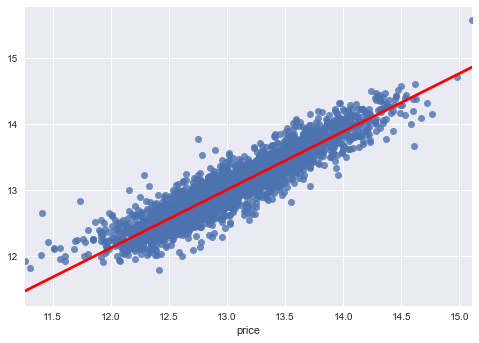

In [153]:
sns.regplot(x = y_test, y = pred_lr3, data = df, line_kws={'color':'r'});

# TEST 2

In [154]:
# Adds dummy zipcode columns
df = df.join(pd.get_dummies(df['grade'], prefix = 'y', drop_first = True))
df.drop('grade', axis=1, inplace=True)

In [155]:
df.head()

,price,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,...,y_4,y_5,y_6,y_7,y_8,y_9,y_10,y_11,y_12,y_13
0,221900.0,1.00,1180,5650,1.0,0.0,0.0,3,1180,0.0,...,0,0,0,1,0,0,0,0,0,0
1,538000.0,2.25,2570,7242,2.0,0.0,0.0,3,2170,400.0,...,0,0,0,1,0,0,0,0,0,0
2,180000.0,1.00,770,10000,1.0,0.0,0.0,3,770,0.0,...,0,0,1,0,0,0,0,0,0,0
3,604000.0,3.00,1960,5000,1.0,0.0,0.0,5,1050,910.0,...,0,0,0,1,0,0,0,0,0,0
4,510000.0,2.00,1680,8080,1.0,0.0,0.0,3,1680,0.0,...,0,0,0,0,1,0,0,0,0,0


In [156]:
# Drop the dependent variable from the independent columns
X = df.drop(['price'], axis = 1)

# Set our dependent variable as the natural log of price
y = np.log(df['price'])

# Split up our independent and dependent variables into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [157]:
# Initialize an empty regression model
lr = LinearRegression()

# Fits the model to our training dataset
lr.fit(X_train, y_train)

LinearRegression()

In [158]:
pred_lr3 = lr.predict(X_test)

In [159]:
# using the score method to see how well our model performed based on how we trained it

train_score_lr3 = lr.score(X_train, y_train)
test_score_lr3 = lr.score(X_test, y_test)

In [160]:
lr.coef_[0]

0.03196606383815397

In [161]:
lr.intercept_

-49.88651507794778

In [162]:
# normalizing our price to get an RMSE

rmse_lr3 = mean_squared_error(np.exp(y_test), np.exp(pred_lr3), squared=False)

In [163]:
train_score_lr3, test_score_lr3, rmse_lr3 # (0.8783623094453447, 0.8702059345827169, 0.19108859922879654)

(0.873661506972752, 0.8713145006833889, 116948.63098731365)

In [164]:
# Making an OLS table to check for significance
X = sm.add_constant(X)
sm.OLS(y, X).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.874
Model:                            OLS   Adj. R-squared:                  0.873
Method:                 Least Squares   F-statistic:                     1416.
Date:                Wed, 14 Jul 2021   Prob (F-statistic):               0.00
Time:                        21:17:51   Log-Likelihood:                 6386.3
No. Observations:               21132   AIC:                        -1.256e+04
Df Residuals:                   21028   BIC:                        -1.174e+04
Df Model:                         103                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 -50.4418      6.961     -7.246      0.000     -64.086     -36.798
bathrooms               0.0192      0.010      1.868      0.062      -0.001       0.039
sqft_living             0.0002   2.19e-05      8.487      0.000       0.000       0.000
sqft_lot             5.721e-07   4.39e-08     13.031      0.000    4.86e-07    6.58e-07
floors                 -0.0424      0.004    -11.500      0.000      -0.050      -0.035
waterfront              0.4713      0.018     26.325      0.000       0.436       0.506
view                    0.0629      0.002     30.850      0.000       0.059       0.067
condition               0.0530      0.002     24.318      0.000       0.049       0.057
sqft_above              0.0001   2.11e-05      5.769      0.000    8.05e-05       0.000
sqft_basement       -2.692e-06   1.73e-05     -0.155      0.877   -3.67e-05    3.13e-05
yr_renovated         3.223e-05   3.64e-06      8.856      0.000    2.51e-05    3.94e-05
lat                     0.5209      0.072      7.279      0.000       0.381       0.661
long                   -0.3070      0.052     -5.947      0.000      -0.408      -0.206
sqft_living15           0.0002   1.03e-05     18.996      0.000       0.000       0.000
sqft_lot15           1.877e-07   7.15e-08      2.625      0.009    4.76e-08    3.28e-07
age                     0.0007   7.41e-05      9.630      0.000       0.001       0.001
x_98002                -0.0007      0.016     -0.045      0.964      -0.033       0.031
x_98003                -0.0023      0.015     -0.157      0.875      -0.031       0.026
x_98004                 0.9418      0.027     35.324      0.000       0.890       0.994
x_98005                 0.5976      0.028     21.100      0.000       0.542       0.653
x_98006                 0.5367      0.023     23.079      0.000       0.491       0.582
x_98007                 0.5229      0.029     17.857      0.000       0.465       0.580
x_98008                 0.5202      0.028     18.729      0.000       0.466       0.575
x_98010                 0.3160      0.025     12.731      0.000       0.267       0.365
x_98011                 0.2244      0.036      6.211      0.000       0.154       0.295
x_98014                 0.2392      0.040      6.004      0.000       0.161       0.317
x_98019                 0.1931      0.039      4.933      0.000       0.116       0.270
x_98022                 0.1608      0.022      7.440      0.000       0.118       0.203
x_98023                -0.0650      0.013     -4.858      0.000      -0.091      -0.039
x_98024                 0.3943      0.035     11.182      0.000       0.325       0.463
x_98027                 0.4589      0.024     19.296      0.000       0.412       0.505
x_98028                 0.1808      0.035      5.154      0.000       0.112       0.250
x_9

In [165]:
scores_simple_3 = cross_validate(
                    lr, X_train, y_train, cv=5, 
                    return_train_score=True
)
simple_3_mean = np.mean(scores_simple_3['train_score'])

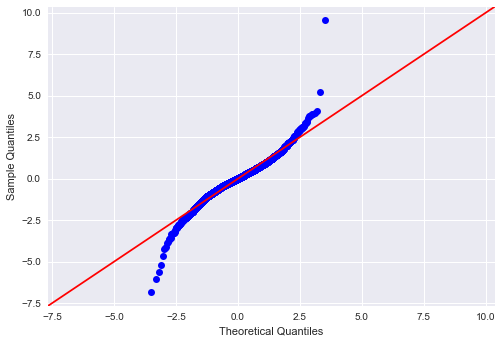

In [166]:
# Making the QQ Plot
residuals3 = (y_test - pred_lr3)
sm.graphics.qqplot(residuals3, dist=stats.norm, line="45", fit=True);

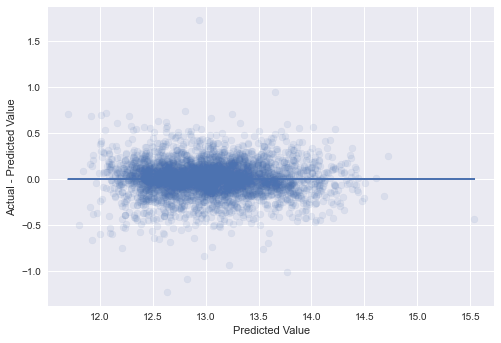

In [167]:
residuals3 = (y_test - pred_lr3)
fig, ax = plt.subplots()
ax.scatter(pred_lr3, residuals3, alpha=.1)
ax.plot(pred_lr3, [0 for i in range(len(X_test))])
ax.set_xlabel('Predicted Value')
ax.set_ylabel('Actual - Predicted Value');

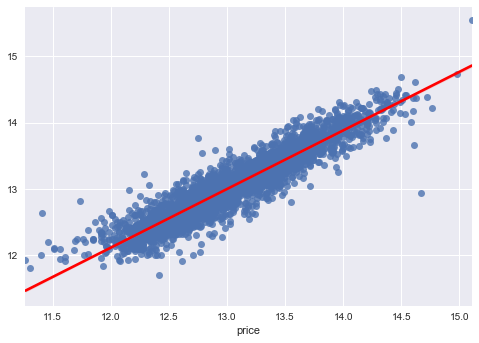

In [168]:
sns.regplot(x = y_test, y = pred_lr3, data = df, line_kws={'color':'r'});

# TEST 3

In [169]:
# Adds dummy zipcode columns
df = df.join(pd.get_dummies(df['view'], prefix = 'z', drop_first = True))
df.drop('view', axis=1, inplace=True)

In [170]:
df.head()

,price,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,sqft_above,sqft_basement,yr_renovated,...,y_8,y_9,y_10,y_11,y_12,y_13,z_1.0,z_2.0,z_3.0,z_4.0
0,221900.0,1.00,1180,5650,1.0,0.0,3,1180,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,538000.0,2.25,2570,7242,2.0,0.0,3,2170,400.0,1991.0,...,0,0,0,0,0,0,0,0,0,0
2,180000.0,1.00,770,10000,1.0,0.0,3,770,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,604000.0,3.00,1960,5000,1.0,0.0,5,1050,910.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,510000.0,2.00,1680,8080,1.0,0.0,3,1680,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0


In [171]:
# Drop the dependent variable from the independent columns
X = df.drop(['price'], axis = 1)

# Set our dependent variable as the natural log of price
y = np.log(df['price'])

# Split up our independent and dependent variables into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [172]:
# Initialize an empty regression model
lr = LinearRegression()

# Fits the model to our training dataset
lr.fit(X_train, y_train)

LinearRegression()

In [173]:
pred_lr3 = lr.predict(X_test)

In [174]:
# using the score method to see how well our model performed based on how we trained it

train_score_lr3 = lr.score(X_train, y_train)
test_score_lr3 = lr.score(X_test, y_test)

In [175]:
lr.coef_[0]

0.03132120593773308

In [176]:
lr.intercept_

-49.48271969429958

In [177]:
# normalizing our price to get an RMSE

rmse_lr3 = mean_squared_error(np.exp(y_test), np.exp(pred_lr3), squared=False)

In [178]:
train_score_lr3, test_score_lr3, rmse_lr3 # (0.8783623094453447, 0.8702059345827169, 0.19108859922879654)

(0.8740372178200331, 0.8712582901495318, 117168.36604794236)

In [179]:
# Making an OLS table to check for significance
X = sm.add_constant(X)
sm.OLS(y, X).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.874
Model:                            OLS   Adj. R-squared:                  0.874
Method:                 Least Squares   F-statistic:                     1380.
Date:                Wed, 14 Jul 2021   Prob (F-statistic):               0.00
Time:                        21:17:53   Log-Likelihood:                 6410.7
No. Observations:               21132   AIC:                        -1.261e+04
Df Residuals:                   21025   BIC:                        -1.176e+04
Df Model:                         106                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 -50.0787      6.954     -7.202      0.000     -63.708     -36.449
bathrooms               0.0192      0.010      1.867      0.062      -0.001       0.039
sqft_living             0.0002   2.19e-05      8.715      0.000       0.000       0.000
sqft_lot             5.761e-07   4.39e-08     13.133      0.000     4.9e-07    6.62e-07
floors                 -0.0423      0.004    -11.476      0.000      -0.050      -0.035
waterfront              0.4274      0.020     21.219      0.000       0.388       0.467
condition               0.0528      0.002     24.247      0.000       0.048       0.057
sqft_above              0.0001   2.11e-05      5.478      0.000    7.44e-05       0.000
sqft_basement       -5.505e-06   1.73e-05     -0.318      0.751   -3.95e-05    2.85e-05
yr_renovated         3.187e-05   3.64e-06      8.763      0.000    2.47e-05     3.9e-05
lat                     0.5205      0.071      7.280      0.000       0.380       0.661
long                   -0.3042      0.052     -5.899      0.000      -0.405      -0.203
sqft_living15           0.0002   1.03e-05     18.855      0.000       0.000       0.000
sqft_lot15           1.883e-07   7.14e-08      2.636      0.008    4.83e-08    3.28e-07
age                     0.0007   7.41e-05      9.722      0.000       0.001       0.001
x_98002                -0.0010      0.016     -0.064      0.949      -0.033       0.031
x_98003                -0.0020      0.015     -0.138      0.890      -0.030       0.026
x_98004                 0.9401      0.027     35.294      0.000       0.888       0.992
x_98005                 0.5971      0.028     21.105      0.000       0.542       0.653
x_98006                 0.5363      0.023     23.087      0.000       0.491       0.582
x_98007                 0.5228      0.029     17.875      0.000       0.465       0.580
x_98008                 0.5193      0.028     18.717      0.000       0.465       0.574
x_98010                 0.3154      0.025     12.722      0.000       0.267       0.364
x_98011                 0.2244      0.036      6.216      0.000       0.154       0.295
x_98014                 0.2391      0.040      6.007      0.000       0.161       0.317
x_98019                 0.1925      0.039      4.923      0.000       0.116       0.269
x_98022                 0.1632      0.022      7.558      0.000       0.121       0.206
x_98023                -0.0648      0.013     -4.851      0.000      -0.091      -0.039
x_98024                 0.3942      0.035     11.192      0.000       0.325       0.463
x_98027                 0.4583      0.024     19.295      0.000       0.412       0.505
x_98028                 0.1800      0.035      5.134      0.000       0.111       0.249
x_98029                 0.5401      0.027     19.886      0.000       0.487       0.593
x_9

In [180]:
scores_simple_3 = cross_validate(
                    lr, X_train, y_train, cv=5, 
                    return_train_score=True
)
simple_3_mean = np.mean(scores_simple_3['train_score'])

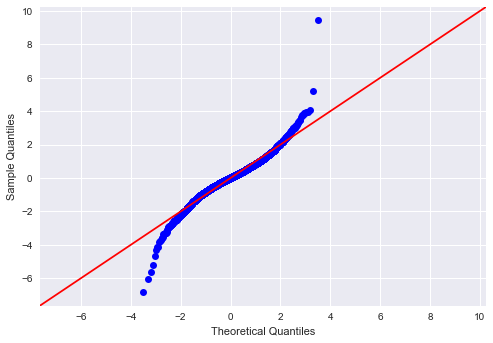

In [181]:
# Making the QQ Plot
residuals3 = (y_test - pred_lr3)
sm.graphics.qqplot(residuals3, dist=stats.norm, line="45", fit=True);

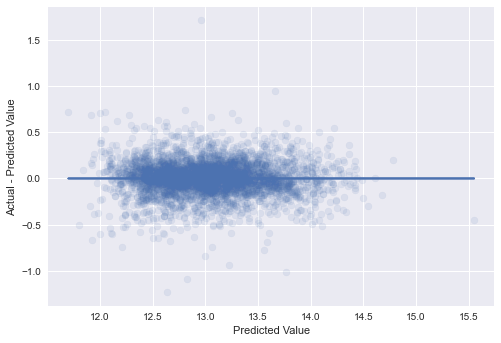

In [182]:
residuals3 = (y_test - pred_lr3)
fig, ax = plt.subplots()
ax.scatter(pred_lr3, residuals3, alpha=.1)
ax.plot(pred_lr3, [0 for i in range(len(X_test))])
ax.set_xlabel('Predicted Value')
ax.set_ylabel('Actual - Predicted Value');

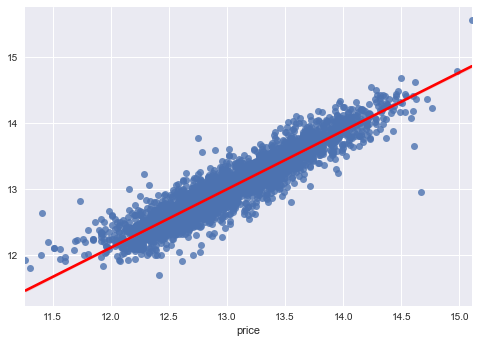

In [183]:
sns.regplot(x = y_test, y = pred_lr3, data = df, line_kws={'color':'r'});

# TEST 4

In [184]:
# Adds dummy zipcode columns
df = df.join(pd.get_dummies(df['bathrooms'], prefix = 'a', drop_first = True))
df.drop('bathrooms', axis=1, inplace=True)

In [185]:
df.head()

,price,sqft_living,sqft_lot,floors,waterfront,condition,sqft_above,sqft_basement,yr_renovated,lat,...,a_2.0,a_2.25,a_2.5,a_2.75,a_3.0,a_3.25,a_3.5,a_3.75,a_4.0,a_4.25
0,221900.0,1180,5650,1.0,0.0,3,1180,0.0,0.0,47.5112,...,0,0,0,0,0,0,0,0,0,0
1,538000.0,2570,7242,2.0,0.0,3,2170,400.0,1991.0,47.7210,...,0,1,0,0,0,0,0,0,0,0
2,180000.0,770,10000,1.0,0.0,3,770,0.0,0.0,47.7379,...,0,0,0,0,0,0,0,0,0,0
3,604000.0,1960,5000,1.0,0.0,5,1050,910.0,0.0,47.5208,...,0,0,0,0,1,0,0,0,0,0
4,510000.0,1680,8080,1.0,0.0,3,1680,0.0,0.0,47.6168,...,1,0,0,0,0,0,0,0,0,0


In [186]:
# Drop the dependent variable from the independent columns
X = df.drop(['price'], axis = 1)

# Set our dependent variable as the natural log of price
y = np.log(df['price'])

# Split up our independent and dependent variables into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [187]:
# Initialize an empty regression model
lr = LinearRegression()

# Fits the model to our training dataset
lr.fit(X_train, y_train)

LinearRegression()

In [188]:
pred_lr3 = lr.predict(X_test)

In [189]:
# using the score method to see how well our model performed based on how we trained it

train_score_lr3 = lr.score(X_train, y_train)
test_score_lr3 = lr.score(X_test, y_test)

In [190]:
lr.coef_[0]

0.00017095567733487987

In [191]:
lr.intercept_

-49.48644933090429

In [192]:
# normalizing our price to get an RMSE

rmse_lr3 = mean_squared_error(np.exp(y_test), np.exp(pred_lr3), squared=False)

In [193]:
train_score_lr3, test_score_lr3, rmse_lr3 # (0.8783623094453447, 0.8702059345827169, 0.19108859922879654)

(0.8742966754238086, 0.8714125861658722, 117406.47700129141)

In [194]:
# Making an OLS table to check for significance
X = sm.add_constant(X)
sm.OLS(y, X).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.875
Model:                            OLS   Adj. R-squared:                  0.874
Method:                 Least Squares   F-statistic:                     1220.
Date:                Wed, 14 Jul 2021   Prob (F-statistic):               0.00
Time:                        21:17:55   Log-Likelihood:                 6428.0
No. Observations:               21132   AIC:                        -1.261e+04
Df Residuals:                   21011   BIC:                        -1.165e+04
Df Model:                         120                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 -50.2127      6.956     -7.219      0.000     -63.847     -36.578
sqft_living             0.0002   2.19e-05      8.573      0.000       0.000       0.000
sqft_lot              5.81e-07   4.39e-08     13.242      0.000    4.95e-07    6.67e-07
floors                 -0.0434      0.004    -11.483      0.000      -0.051      -0.036
waterfront              0.4270      0.020     21.174      0.000       0.387       0.467
condition               0.0526      0.002     24.095      0.000       0.048       0.057
sqft_above              0.0001   2.12e-05      5.687      0.000    7.89e-05       0.000
sqft_basement       -5.542e-06   1.73e-05     -0.320      0.749   -3.95e-05    2.84e-05
yr_renovated         3.221e-05   3.64e-06      8.850      0.000    2.51e-05    3.93e-05
lat                     0.5178      0.072      7.241      0.000       0.378       0.658
long                   -0.3049      0.052     -5.908      0.000      -0.406      -0.204
sqft_living15           0.0002   1.03e-05     18.578      0.000       0.000       0.000
sqft_lot15           1.874e-07   7.14e-08      2.624      0.009    4.74e-08    3.27e-07
age                     0.0007   7.45e-05      9.941      0.000       0.001       0.001
x_98002                -0.0006      0.016     -0.036      0.971      -0.032       0.031
x_98003                -0.0022      0.014     -0.152      0.879      -0.031       0.026
x_98004                 0.9414      0.027     35.337      0.000       0.889       0.994
x_98005                 0.5967      0.028     21.086      0.000       0.541       0.652
x_98006                 0.5360      0.023     23.065      0.000       0.490       0.582
x_98007                 0.5240      0.029     17.910      0.000       0.467       0.581
x_98008                 0.5193      0.028     18.710      0.000       0.465       0.574
x_98010                 0.3154      0.025     12.722      0.000       0.267       0.364
x_98011                 0.2241      0.036      6.210      0.000       0.153       0.295
x_98014                 0.2394      0.040      6.013      0.000       0.161       0.317
x_98019                 0.1925      0.039      4.923      0.000       0.116       0.269
x_98022                 0.1639      0.022      7.592      0.000       0.122       0.206
x_98023                -0.0658      0.013     -4.921      0.000      -0.092      -0.040
x_98024                 0.3951      0.035     11.215      0.000       0.326       0.464
x_98027                 0.4587      0.024     19.298      0.000       0.412       0.505
x_98028                 0.1807      0.035      5.154      0.000       0.112       0.249
x_98029                 0.5393      0.027     19.843      0.000       0.486       0.593
x_98030                 0.0401      0.016      2.519      0.012       0.009       0.071
x_9

In [195]:
scores_simple_3 = cross_validate(
                    lr, X_train, y_train, cv=5, 
                    return_train_score=True
)
simple_3_mean = np.mean(scores_simple_3['train_score'])

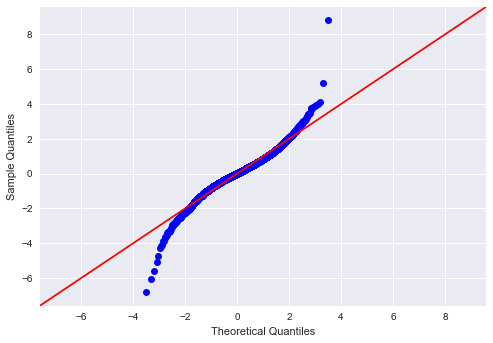

In [196]:
# Making the QQ Plot
residuals3 = (y_test - pred_lr3)
sm.graphics.qqplot(residuals3, dist=stats.norm, line="45", fit=True);

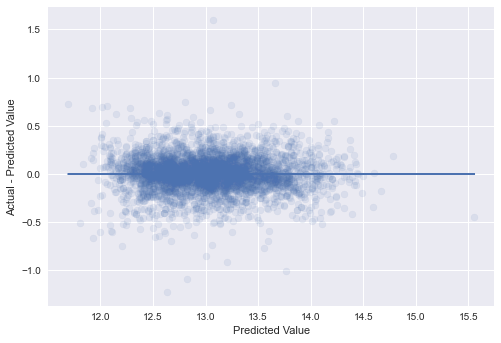

In [197]:
residuals3 = (y_test - pred_lr3)
fig, ax = plt.subplots()
ax.scatter(pred_lr3, residuals3, alpha=.1)
ax.plot(pred_lr3, [0 for i in range(len(X_test))])
ax.set_xlabel('Predicted Value')
ax.set_ylabel('Actual - Predicted Value');

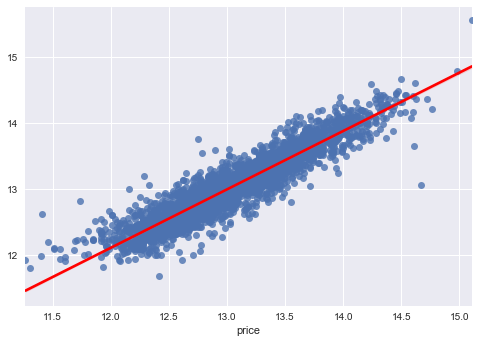

In [198]:
sns.regplot(x = y_test, y = pred_lr3, data = df, line_kws={'color':'r'});

# TEST 5

In [199]:
# Adds dummy zipcode columns
df = df.join(pd.get_dummies(df['condition'], prefix = 'b', drop_first = True))
df.drop('condition', axis=1, inplace=True)

In [200]:
df.head()

,price,sqft_living,sqft_lot,floors,waterfront,sqft_above,sqft_basement,yr_renovated,lat,long,...,a_3.0,a_3.25,a_3.5,a_3.75,a_4.0,a_4.25,b_2,b_3,b_4,b_5
0,221900.0,1180,5650,1.0,0.0,1180,0.0,0.0,47.5112,-122.257,...,0,0,0,0,0,0,0,1,0,0
1,538000.0,2570,7242,2.0,0.0,2170,400.0,1991.0,47.7210,-122.319,...,0,0,0,0,0,0,0,1,0,0
2,180000.0,770,10000,1.0,0.0,770,0.0,0.0,47.7379,-122.233,...,0,0,0,0,0,0,0,1,0,0
3,604000.0,1960,5000,1.0,0.0,1050,910.0,0.0,47.5208,-122.393,...,1,0,0,0,0,0,0,0,0,1
4,510000.0,1680,8080,1.0,0.0,1680,0.0,0.0,47.6168,-122.045,...,0,0,0,0,0,0,0,1,0,0


In [201]:
# Drop the dependent variable from the independent columns
X = df.drop(['price'], axis = 1)

# Set our dependent variable as the natural log of price
y = np.log(df['price'])

# Split up our independent and dependent variables into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [202]:
# Initialize an empty regression model
lr = LinearRegression()

# Fits the model to our training dataset
lr.fit(X_train, y_train)

LinearRegression()

In [203]:
pred_lr3 = lr.predict(X_test)

In [204]:
# using the score method to see how well our model performed based on how we trained it

train_score_lr3 = lr.score(X_train, y_train)
test_score_lr3 = lr.score(X_test, y_test)

In [205]:
lr.coef_[0]

0.0001718497891441608

In [206]:
lr.intercept_

-49.348344873022675

In [207]:
# normalizing our price to get an RMSE

rmse_lr3 = mean_squared_error(np.exp(y_test), np.exp(pred_lr3), squared=False)

In [208]:
train_score_lr3, test_score_lr3, rmse_lr3 # (0.8783623094453447, 0.8702059345827169, 0.19108859922879654)

(0.8746785611698893, 0.871739845349928, 117215.6306977647)

In [209]:
# Making an OLS table to check for significance
X = sm.add_constant(X)
sm.OLS(y, X).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.875
Model:                            OLS   Adj. R-squared:                  0.874
Method:                 Least Squares   F-statistic:                     1194.
Date:                Wed, 14 Jul 2021   Prob (F-statistic):               0.00
Time:                        21:17:57   Log-Likelihood:                 6459.7
No. Observations:               21132   AIC:                        -1.267e+04
Df Residuals:                   21008   BIC:                        -1.168e+04
Df Model:                         123                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 -49.9224      6.946     -7.187      0.000     -63.538     -36.307
sqft_living             0.0002   2.19e-05      8.620      0.000       0.000       0.000
sqft_lot             5.898e-07   4.38e-08     13.458      0.000    5.04e-07    6.76e-07
floors                 -0.0440      0.004    -11.645      0.000      -0.051      -0.037
waterfront              0.4263      0.020     21.168      0.000       0.387       0.466
sqft_above              0.0001   2.11e-05      5.643      0.000    7.79e-05       0.000
sqft_basement       -6.741e-06   1.73e-05     -0.390      0.697   -4.07e-05    2.72e-05
yr_renovated         3.018e-05   3.64e-06      8.282      0.000     2.3e-05    3.73e-05
lat                     0.5095      0.071      7.134      0.000       0.370       0.650
long                   -0.3046      0.052     -5.912      0.000      -0.406      -0.204
sqft_living15           0.0002   1.03e-05     18.769      0.000       0.000       0.000
sqft_lot15           1.884e-07   7.13e-08      2.640      0.008    4.85e-08    3.28e-07
age                     0.0008   7.49e-05     10.846      0.000       0.001       0.001
x_98002             -3.433e-05      0.016     -0.002      0.998      -0.032       0.032
x_98003                -0.0021      0.014     -0.143      0.886      -0.030       0.026
x_98004                 0.9457      0.027     35.530      0.000       0.894       0.998
x_98005                 0.6017      0.028     21.282      0.000       0.546       0.657
x_98006                 0.5409      0.023     23.293      0.000       0.495       0.586
x_98007                 0.5280      0.029     18.064      0.000       0.471       0.585
x_98008                 0.5225      0.028     18.846      0.000       0.468       0.577
x_98010                 0.3151      0.025     12.726      0.000       0.267       0.364
x_98011                 0.2271      0.036      6.299      0.000       0.156       0.298
x_98014                 0.2413      0.040      6.070      0.000       0.163       0.319
x_98019                 0.1944      0.039      4.977      0.000       0.118       0.271
x_98022                 0.1628      0.022      7.552      0.000       0.121       0.205
x_98023                -0.0640      0.013     -4.791      0.000      -0.090      -0.038
x_98024                 0.3952      0.035     11.231      0.000       0.326       0.464
x_98027                 0.4609      0.024     19.411      0.000       0.414       0.507
x_98028                 0.1834      0.035      5.238      0.000       0.115       0.252
x_98029                 0.5411      0.027     19.934      0.000       0.488       0.594
x_98030                 0.0408      0.016      2.563      0.010       0.010       0.072
x_98031                 0.0456      0.017      2.745      0.006       0.013       0.078
x_9

In [210]:
scores_simple_3 = cross_validate(
                    lr, X_train, y_train, cv=5, 
                    return_train_score=True
)
simple_3_mean = np.mean(scores_simple_3['train_score'])

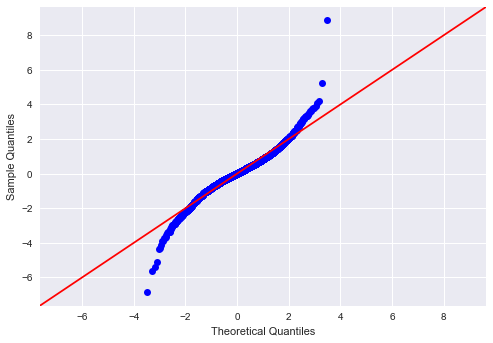

In [211]:
# Making the QQ Plot
residuals3 = (y_test - pred_lr3)
sm.graphics.qqplot(residuals3, dist=stats.norm, line="45", fit=True);

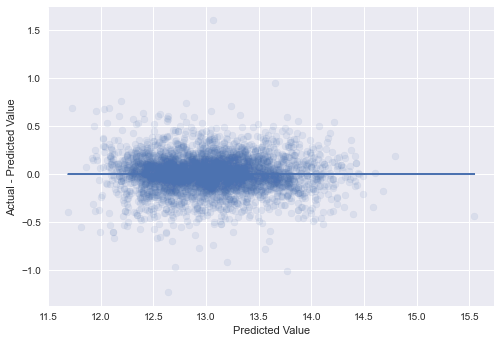

In [212]:
residuals3 = (y_test - pred_lr3)
fig, ax = plt.subplots()
ax.scatter(pred_lr3, residuals3, alpha=.1)
ax.plot(pred_lr3, [0 for i in range(len(X_test))])
ax.set_xlabel('Predicted Value')
ax.set_ylabel('Actual - Predicted Value');

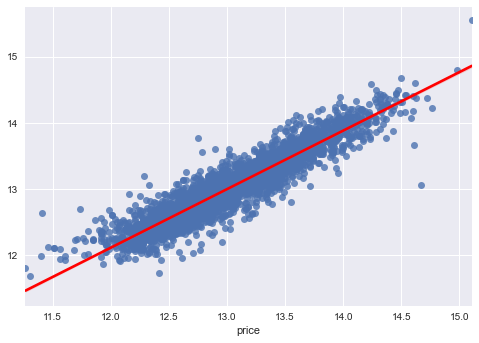

In [213]:
sns.regplot(x = y_test, y = pred_lr3, data = df, line_kws={'color':'r'});

# TEST 6

In [214]:
df.columns

Index(['price', 'sqft_living', 'sqft_lot', 'floors', 'waterfront',
       'sqft_above', 'sqft_basement', 'yr_renovated', 'lat', 'long',
       ...
       'a_3.0', 'a_3.25', 'a_3.5', 'a_3.75', 'a_4.0', 'a_4.25', 'b_2', 'b_3',
       'b_4', 'b_5'],
      dtype='object', length=124)

In [215]:
# Adds dummy zipcode columns
df = df.join(pd.get_dummies(df['waterfront'], prefix = 'c', drop_first = True))
df.drop('waterfront', axis=1, inplace=True)

In [216]:
df.head()

,price,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,yr_renovated,lat,long,sqft_living15,...,a_3.25,a_3.5,a_3.75,a_4.0,a_4.25,b_2,b_3,b_4,b_5,c_1.0
0,221900.0,1180,5650,1.0,1180,0.0,0.0,47.5112,-122.257,1340,...,0,0,0,0,0,0,1,0,0,0
1,538000.0,2570,7242,2.0,2170,400.0,1991.0,47.7210,-122.319,1690,...,0,0,0,0,0,0,1,0,0,0
2,180000.0,770,10000,1.0,770,0.0,0.0,47.7379,-122.233,2720,...,0,0,0,0,0,0,1,0,0,0
3,604000.0,1960,5000,1.0,1050,910.0,0.0,47.5208,-122.393,1360,...,0,0,0,0,0,0,0,0,1,0
4,510000.0,1680,8080,1.0,1680,0.0,0.0,47.6168,-122.045,1800,...,0,0,0,0,0,0,1,0,0,0


In [217]:
# Drop the dependent variable from the independent columns
X = df.drop(['price'], axis = 1)

# Set our dependent variable as the natural log of price
y = np.log(df['price'])

# Split up our independent and dependent variables into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [218]:
# Initialize an empty regression model
lr = LinearRegression()

# Fits the model to our training dataset
lr.fit(X_train, y_train)

LinearRegression()

In [219]:
pred_lr3 = lr.predict(X_test)

In [220]:
# using the score method to see how well our model performed based on how we trained it

train_score_lr3 = lr.score(X_train, y_train)
test_score_lr3 = lr.score(X_test, y_test)

In [221]:
lr.coef_[0]

0.00017184978907978948

In [222]:
lr.intercept_

-49.348344865780774

In [223]:
# normalizing our price to get an RMSE

rmse_lr3 = mean_squared_error(np.exp(y_test), np.exp(pred_lr3), squared=False)

In [224]:
train_score_lr3, test_score_lr3, rmse_lr3 # (0.8783623094453447, 0.8702059345827169, 0.19108859922879654)

(0.8746785611698893, 0.8717398453486456, 117215.63070270313)

In [225]:
# Making an OLS table to check for significance
X = sm.add_constant(X)
sm.OLS(y, X).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.875
Model:                            OLS   Adj. R-squared:                  0.874
Method:                 Least Squares   F-statistic:                     1194.
Date:                Wed, 14 Jul 2021   Prob (F-statistic):               0.00
Time:                        21:18:00   Log-Likelihood:                 6459.7
No. Observations:               21132   AIC:                        -1.267e+04
Df Residuals:                   21008   BIC:                        -1.168e+04
Df Model:                         123                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 -49.9224      6.946     -7.187      0.000     -63.538     -36.307
sqft_living             0.0002   2.19e-05      8.620      0.000       0.000       0.000
sqft_lot             5.898e-07   4.38e-08     13.458      0.000    5.04e-07    6.76e-07
floors                 -0.0440      0.004    -11.645      0.000      -0.051      -0.037
sqft_above              0.0001   2.11e-05      5.643      0.000    7.79e-05       0.000
sqft_basement       -6.741e-06   1.73e-05     -0.390      0.697   -4.07e-05    2.72e-05
yr_renovated         3.018e-05   3.64e-06      8.282      0.000     2.3e-05    3.73e-05
lat                     0.5095      0.071      7.134      0.000       0.370       0.650
long                   -0.3046      0.052     -5.912      0.000      -0.406      -0.204
sqft_living15           0.0002   1.03e-05     18.769      0.000       0.000       0.000
sqft_lot15           1.884e-07   7.13e-08      2.640      0.008    4.85e-08    3.28e-07
age                     0.0008   7.49e-05     10.846      0.000       0.001       0.001
x_98002             -3.433e-05      0.016     -0.002      0.998      -0.032       0.032
x_98003                -0.0021      0.014     -0.143      0.886      -0.030       0.026
x_98004                 0.9457      0.027     35.530      0.000       0.894       0.998
x_98005                 0.6017      0.028     21.282      0.000       0.546       0.657
x_98006                 0.5409      0.023     23.293      0.000       0.495       0.586
x_98007                 0.5280      0.029     18.064      0.000       0.471       0.585
x_98008                 0.5225      0.028     18.846      0.000       0.468       0.577
x_98010                 0.3151      0.025     12.726      0.000       0.267       0.364
x_98011                 0.2271      0.036      6.299      0.000       0.156       0.298
x_98014                 0.2413      0.040      6.070      0.000       0.163       0.319
x_98019                 0.1944      0.039      4.977      0.000       0.118       0.271
x_98022                 0.1628      0.022      7.552      0.000       0.121       0.205
x_98023                -0.0640      0.013     -4.791      0.000      -0.090      -0.038
x_98024                 0.3952      0.035     11.231      0.000       0.326       0.464
x_98027                 0.4609      0.024     19.411      0.000       0.414       0.507
x_98028                 0.1834      0.035      5.238      0.000       0.115       0.252
x_98029                 0.5411      0.027     19.934      0.000       0.488       0.594
x_98030                 0.0408      0.016      2.563      0.010       0.010       0.072
x_98031                 0.0456      0.017      2.745      0.006       0.013       0.078
x_98032                -0.0666      0.019     -3.448      0.001      -0.104      -0.029
x_9

In [226]:
scores_simple_3 = cross_validate(
                    lr, X_train, y_train, cv=5, 
                    return_train_score=True
)
simple_3_mean = np.mean(scores_simple_3['train_score'])

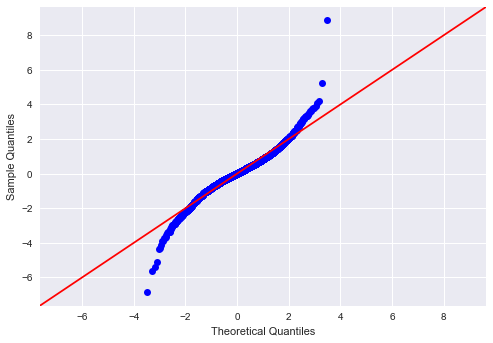

In [227]:
# Making the QQ Plot
residuals3 = (y_test - pred_lr3)
sm.graphics.qqplot(residuals3, dist=stats.norm, line="45", fit=True);

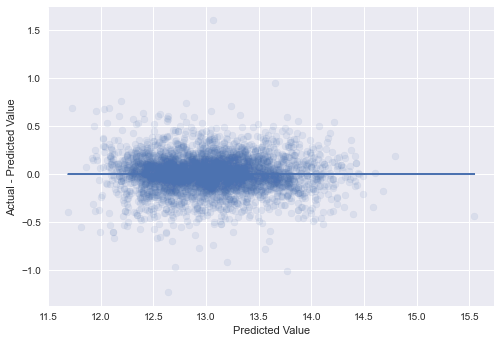

In [228]:
residuals3 = (y_test - pred_lr3)
fig, ax = plt.subplots()
ax.scatter(pred_lr3, residuals3, alpha=.1)
ax.plot(pred_lr3, [0 for i in range(len(X_test))])
ax.set_xlabel('Predicted Value')
ax.set_ylabel('Actual - Predicted Value');

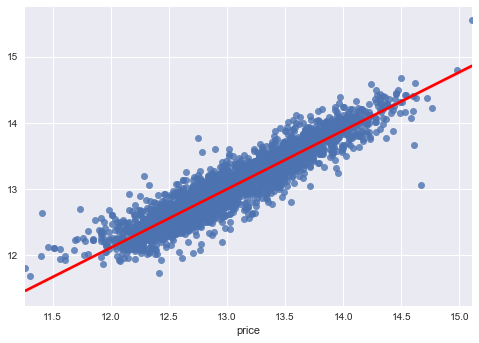

In [229]:
sns.regplot(x = y_test, y = pred_lr3, data = df, line_kws={'color':'r'});

# TEST 7

In [230]:
# Adds dummy zipcode columns
df = df.join(pd.get_dummies(df['floors'], prefix = 'd', drop_first = True))
df.drop('floors', axis=1, inplace=True)

In [231]:
df.head()

,price,sqft_living,sqft_lot,sqft_above,sqft_basement,yr_renovated,lat,long,sqft_living15,sqft_lot15,...,b_2,b_3,b_4,b_5,c_1.0,d_1.5,d_2.0,d_2.5,d_3.0,d_3.5
0,221900.0,1180,5650,1180,0.0,0.0,47.5112,-122.257,1340,5650,...,0,1,0,0,0,0,0,0,0,0
1,538000.0,2570,7242,2170,400.0,1991.0,47.7210,-122.319,1690,7639,...,0,1,0,0,0,0,1,0,0,0
2,180000.0,770,10000,770,0.0,0.0,47.7379,-122.233,2720,8062,...,0,1,0,0,0,0,0,0,0,0
3,604000.0,1960,5000,1050,910.0,0.0,47.5208,-122.393,1360,5000,...,0,0,0,1,0,0,0,0,0,0
4,510000.0,1680,8080,1680,0.0,0.0,47.6168,-122.045,1800,7503,...,0,1,0,0,0,0,0,0,0,0


In [232]:
# Drop the dependent variable from the independent columns
X = df.drop(['price'], axis = 1)

# Set our dependent variable as the natural log of price
y = np.log(df['price'])

# Split up our independent and dependent variables into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [233]:
# Initialize an empty regression model
lr = LinearRegression()

# Fits the model to our training dataset
lr.fit(X_train, y_train)

LinearRegression()

In [234]:
pred_lr3 = lr.predict(X_test)

In [235]:
# using the score method to see how well our model performed based on how we trained it

train_score_lr3 = lr.score(X_train, y_train)
test_score_lr3 = lr.score(X_test, y_test)

In [236]:
lr.coef_[0]

0.00017560306709368746

In [237]:
lr.intercept_

-51.91456885707698

In [238]:
# normalizing our price to get an RMSE

rmse_lr3 = mean_squared_error(np.exp(y_test), np.exp(pred_lr3), squared=False)

In [239]:
train_score_lr3, test_score_lr3, rmse_lr3 # (0.8783623094453447, 0.8702059345827169, 0.19108859922879654)

(0.8750702165270445, 0.8720283766066046, 117489.6826900085)

In [240]:
# Making an OLS table to check for significance
X = sm.add_constant(X)
sm.OLS(y, X).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.875
Model:                            OLS   Adj. R-squared:                  0.874
Method:                 Least Squares   F-statistic:                     1160.
Date:                Wed, 14 Jul 2021   Prob (F-statistic):               0.00
Time:                        21:18:02   Log-Likelihood:                 6490.5
No. Observations:               21132   AIC:                        -1.273e+04
Df Residuals:                   21004   BIC:                        -1.171e+04
Df Model:                         127                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 -52.5168      6.946     -7.561      0.000     -66.131     -38.902
sqft_living             0.0002   2.19e-05      8.771      0.000       0.000       0.000
sqft_lot             5.935e-07   4.38e-08     13.552      0.000    5.08e-07    6.79e-07
sqft_above              0.0001   2.12e-05      4.971      0.000    6.38e-05       0.000
sqft_basement       -6.203e-06   1.73e-05     -0.359      0.720   -4.01e-05    2.77e-05
yr_renovated         3.142e-05   3.65e-06      8.612      0.000    2.43e-05    3.86e-05
lat                     0.5107      0.071      7.160      0.000       0.371       0.651
long                   -0.3252      0.052     -6.309      0.000      -0.426      -0.224
sqft_living15           0.0002   1.03e-05     18.784      0.000       0.000       0.000
sqft_lot15           1.907e-07   7.13e-08      2.675      0.007     5.1e-08     3.3e-07
age                     0.0006   7.97e-05      7.859      0.000       0.000       0.001
x_98002                 0.0016      0.016      0.099      0.921      -0.030       0.033
x_98003                -0.0016      0.014     -0.109      0.913      -0.030       0.027
x_98004                 0.9514      0.027     35.776      0.000       0.899       1.004
x_98005                 0.6078      0.028     21.517      0.000       0.552       0.663
x_98006                 0.5456      0.023     23.517      0.000       0.500       0.591
x_98007                 0.5335      0.029     18.268      0.000       0.476       0.591
x_98008                 0.5297      0.028     19.118      0.000       0.475       0.584
x_98010                 0.3181      0.025     12.867      0.000       0.270       0.367
x_98011                 0.2284      0.036      6.344      0.000       0.158       0.299
x_98014                 0.2461      0.040      6.196      0.000       0.168       0.324
x_98019                 0.1976      0.039      5.065      0.000       0.121       0.274
x_98022                 0.1677      0.022      7.783      0.000       0.125       0.210
x_98023                -0.0650      0.013     -4.873      0.000      -0.091      -0.039
x_98024                 0.4033      0.035     11.471      0.000       0.334       0.472
x_98027                 0.4639      0.024     19.559      0.000       0.417       0.510
x_98028                 0.1847      0.035      5.281      0.000       0.116       0.253
x_98029                 0.5422      0.027     19.988      0.000       0.489       0.595
x_98030                 0.0421      0.016      2.651      0.008       0.011       0.073
x_98031                 0.0474      0.017      2.856      0.004       0.015       0.080
x_98032                -0.0663      0.019     -3.440      0.001      -0.104      -0.029
x_98033                 0.6006      0.030     19.996      0.000       0.542       0.660
x_9

In [241]:
scores_simple_3 = cross_validate(
                    lr, X_train, y_train, cv=5, 
                    return_train_score=True
)
simple_3_mean = np.mean(scores_simple_3['train_score'])

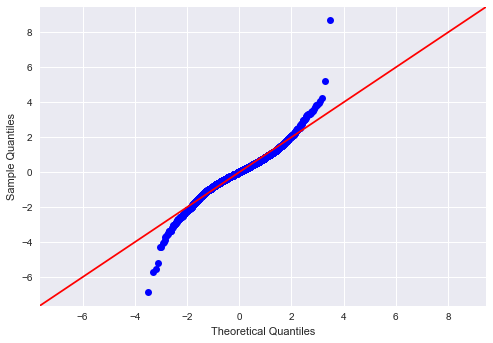

In [242]:
# Making the QQ Plot
residuals3 = (y_test - pred_lr3)
sm.graphics.qqplot(residuals3, dist=stats.norm, line="45", fit=True);

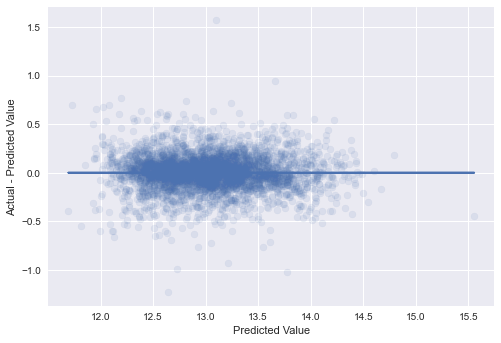

In [243]:
residuals3 = (y_test - pred_lr3)
fig, ax = plt.subplots()
ax.scatter(pred_lr3, residuals3, alpha=.1)
ax.plot(pred_lr3, [0 for i in range(len(X_test))])
ax.set_xlabel('Predicted Value')
ax.set_ylabel('Actual - Predicted Value');

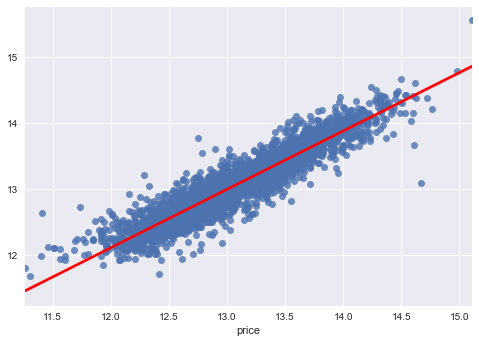

In [244]:
sns.regplot(x = y_test, y = pred_lr3, data = df, line_kws={'color':'r'});

In [245]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 236.20360565185547 seconds ---
